In [1]:
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import time
import sys, io

import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [3]:
def _get_hidden_neuron_number(i, o):
    return (max(i,o)*(min(i,o)**2))**(1/3)


class Shortcut_Conv(nn.Module):

    def __init__(self, tree, input_dim, output_dim, kernel=(3,3), stride=1):
        super().__init__()
        self.tree = tree
        self._kernel = np.array(kernel, dtype=int)
        self._padding = tuple(((self._kernel-1)/2).astype(int))
        self._stride = stride
        _wd = nn.Conv2d(input_dim, output_dim, self._kernel, stride=self._stride,
                        padding=self._padding, bias=False).weight.data
        ## Shape = OutputDim, InputDim, Kernel0, Kernel1
        self.weight = nn.Parameter(
            torch.empty_like(_wd).copy_(_wd)
        )
        del _wd
    
        ## for removing and freezing neurons
        self.to_remove = None
        self.to_freeze = None
        self.initial_remove = None
        self.initial_freeze = None
    
    def forward(self, x):
        if x.shape[1] > 0 and self.weight.shape[0] > 0:
            return F.conv2d(x, self.weight, stride=self._stride, padding=self._padding)
        ### output dim is 0
        elif self.weight.shape[0] == 0:
            ###             #num_inp  #inp_dim    #feature
            x = torch.zeros(x.shape[0], 1, x.shape[2], x.shape[3], dtype=x.dtype, device=x.device)
            ###       #out_dim #inp_dim            #kernel
            w = torch.zeros(1, 1, self.weight.shape[2], self.weight.shape[3], dtype=x.dtype, device=x.device)
            o = F.conv2d(x, w, stride=self._stride, padding=self._padding)
            return torch.zeros(o.shape[0], 0, o.shape[2], o.shape[3], dtype=x.dtype, device=x.device)
        ### input dim is 0
        elif x.shape[1] == 0:
            ###             #num_inp  #inp_dim    #feature
            x = torch.zeros(x.shape[0], 1, x.shape[2], x.shape[3], dtype=x.dtype, device=x.device)
            ###             #out_dim            #inp_dim            #kernel
            w = torch.zeros(self.weight.shape[0], 1, self.weight.shape[2], self.weight.shape[3], dtype=x.dtype, device=x.device)
            o = F.conv2d(x, w, stride=self._stride, padding=self._padding)
            return o.data
        else:
            raise(f"Unknown shape of input {x.shape} or weight {self.weight.shape}")

#     def decay_std_ratio(self, factor):
#         self.weight.data = self.weight.data - self.tree.decay_rate_std*factor.t()*self.weight.data
        
#     def decay_std_ratio_grad(self, factor):
#         self.weight.grad = self.weight.grad + self.tree.decay_rate_std*factor.t()*self.weight.data
    
    def start_decaying_connection(self, to_remove):
        self.initial_remove = self.weight.data[:, to_remove]
        self.to_remove = to_remove
        self.tree.decay_connection_shortcut.add(self)
        pass
    
    def start_freezing_connection(self, to_freeze):
        self.initial_freeze = self.weight.data[to_freeze, :]
        self.to_freeze = to_freeze
        self.tree.freeze_connection_shortcut.add(self)
        pass
    
    def freeze_connection_step(self):#, to_freeze):
        self.weight.data[self.to_freeze, :] = self.initial_freeze
        pass
    
    def decay_connection_step(self):#, to_remove):
        self.weight.data[:, self.to_remove] = self.initial_remove*self.tree.decay_factor
        pass
     
    def remove_freezed_connection(self, remaining):
        # print(self.weight.data.shape, "removing freezed; ", self.to_freeze)
        _w = self.weight.data[remaining, :]
        del self.weight
        self.weight = nn.Parameter(_w)
        self.initial_freeze = None
        self.to_freeze = None
        pass
    
    def remove_decayed_connection(self, remaining):
        # print(self.weight.data.shape, "removing decayed; ", self.to_remove)
        _w = self.weight.data[:, remaining]
        del self.weight
        self.weight = nn.Parameter(_w)
        self.initial_remove = None
        self.to_remove = None
        pass
    
    def add_input_connection(self, num):
        # print(self.weight.data.shape)
        o, i, k0, k1 = self.weight.data.shape
        _w = torch.cat((self.weight.data, torch.zeros(o, num, k0, k1, dtype=self.weight.data.dtype,
                                                      device=self.weight.data.device)), dim=1)
        del self.weight
        self.weight = nn.Parameter(_w)
        # print(self.weight.data.shape)
        pass

    def add_output_connection(self, num):
        # print(self.weight.data.shape)
        o, i, k0, k1 = self.weight.data.shape
        stdv = 1. / np.sqrt(i)
        _new = torch.empty(num, i, k0, k1, dtype=self.weight.data.dtype,
                           device=self.weight.data.device).uniform_(-stdv, stdv)
        
        _w = torch.cat((self.weight.data, _new), dim=0)
        del self.weight
        self.weight = nn.Parameter(_w)
        # print(self.weight.data.shape)        
        pass
    
    def print_network_debug(self, depth):
        print(f"{'║     '*depth}S▚:{depth}[{self.weight.data.shape[1]},{self.weight.data.shape[0]}]")



In [4]:
class NonLinearity_Conv(nn.Module):

    def __init__(self, tree, io_dim, actf_obj=nn.ReLU()):
        super().__init__()
        self.tree = tree
        self.bias = nn.Parameter(torch.zeros(io_dim))
        self.actf = actf_obj

    def forward(self, x):
        return self.actf(x+self.bias.view(1,-1,1,1))

    def add_neuron(self, num):
        _b = torch.cat((self.bias.data, torch.zeros(num, dtype=self.bias.data.dtype,
                                                    device=self.bias.data.device)))
        del self.bias
        self.bias = nn.Parameter(_b)
        
    def remove_neuron(self, remaining):
        _b = self.bias.data[remaining]
        del self.bias
        self.bias = nn.Parameter(_b)

In [5]:
class NonLinearity(nn.Module):

    def __init__(self, tree, io_dim, actf_obj=nn.ReLU()):
        super().__init__()
        self.tree = tree
        self.bias = nn.Parameter(torch.zeros(io_dim))
        self.actf = actf_obj

    def forward(self, x):
        return self.actf(x+self.bias)

    def add_neuron(self, num):
        _b = torch.cat((self.bias.data, torch.zeros(num, dtype=self.bias.data.dtype,
                                                    device=self.bias.data.device)))
        del self.bias
        self.bias = nn.Parameter(_b)
        
    def remove_neuron(self, remaining):
        _b = self.bias.data[remaining]
        del self.bias
        self.bias = nn.Parameter(_b)

In [6]:
class Residual_Conv(nn.Module):

    def __init__(self, tree, input_dim, hidden_dim, output_dim, stride=1):
        super().__init__()
        self.tree = tree
        self.hidden_dim = hidden_dim
#         self.stride = stride
        self.del_neurons = 0.
        self.neurons_added = 0

        ## Shortcut or Hierarchical Residual Layer
        self.fc0 = HierarchicalResidual_Conv(self.tree, input_dim, hidden_dim, stride=stride) 
        self.non_linearity = NonLinearity_Conv(self.tree, hidden_dim)
        self.fc1 = HierarchicalResidual_Conv(self.tree, hidden_dim, output_dim)
        self.fc1.shortcut.weight.data *= 0.
        
        self.tree.parent_dict[self.fc0] = self
        self.tree.parent_dict[self.fc1] = self
        self.tree.parent_dict[self.non_linearity] = self
        
        self.hook = None
        self.activations = None
        self.significance = None
        self.count = None
        self.apnz = None
        self.to_remove = None
    
    def forward(self, x):
        x = self.fc0(x)
        x = self.non_linearity(x)
        self.activations = x.data
        x = self.fc1(x)
        return x
    
    def start_computing_significance(self):
        self.significance = 0.
        self.count = 0
        self.apnz = 0
        self.hook = self.non_linearity.register_backward_hook(self.compute_neuron_significance)
        pass
            
    def finish_computing_significance(self):
        self.hook.remove()
        self.significance = self.significance#/self.count
        self.apnz = self.apnz/self.count
#         print(f"Significance before rethinking(apnz)\n{self.significance}")
#         print(f"Apnz\n{self.apnz}")
        self.significance = self.significance*(1-self.apnz) * 4 ## tried on desmos.
#         print(f"Significance after rethinking(apnz)\n{self.significance}")
        self.count = None
        self.hook = None
        pass
    
    def compute_neuron_significance(self, _class, grad_input, grad_output):
        with torch.no_grad():
            z = torch.sum(grad_output[0].data*self.activations, dim=(2,3))
            self.significance += z.pow(2).sum(dim=0)
            self.count += grad_output[0].shape[0]*grad_output[0].shape[2]*grad_output[0].shape[3]
    #         self.apnz += torch.count_nonzero(self.activations.data, dim=0)
            self.apnz += torch.sum(self.activations > 0., dim=(0,2,3), dtype=z.dtype).to(z.device)
        pass
    
    def identify_removable_neurons(self, below):
        if self.to_remove is not None:
            print("First remove all previous less significant neurons")
            return
        
        self.to_remove = torch.nonzero(self.significance<=below).reshape(-1)
        if len(self.to_remove)>0:
            self.fc0.start_freezing_connection(self.to_remove)
            self.fc1.start_decaying_connection(self.to_remove)
            self.tree.remove_neuron_residual.add(self)
            return len(self.to_remove)
        
        self.to_remove = None
        return 0

    def remove_decayed_neurons(self):
        remaining = []
        for i in range(self.hidden_dim):
            if i not in self.to_remove:
                remaining.append(i)
        
        self.non_linearity.remove_neuron(remaining)
        self.fc0.remove_freezed_connection(remaining)
        self.fc1.remove_decayed_connection(remaining)
        
        self.neurons_added -= len(self.to_remove)
        self.hidden_dim = len(remaining)
        self.to_remove = None
        pass
    
    def compute_del_neurons(self):
        self.del_neurons = (1-self.tree.beta_del_neuron)*self.neurons_added \
                            + self.tree.beta_del_neuron*self.del_neurons
        self.neurons_added = 0
        return
    
    def add_hidden_neuron(self, num):
        self.fc0.add_output_connection(num)
        self.non_linearity.add_neuron(num)
        self.fc1.add_input_connection(num)
        
        self.hidden_dim += num
        self.neurons_added += num
        pass

    def morph_network(self):
        self.fc0.morph_network()
        self.fc1.morph_network()
#         max_dim = np.ceil((self.tree.parent_dict[self].input_dim+\
#             self.tree.parent_dict[self].output_dim)/2)
        max_dim = _get_hidden_neuron_number(self.tree.parent_dict[self].input_dim,
            self.tree.parent_dict[self].output_dim)+1
        if self.hidden_dim <= max_dim:
            if self.fc0.residual is None:
                if self.fc0 in self.tree.DYNAMIC_LIST:
                    self.tree.DYNAMIC_LIST.remove(self.fc0)
            if self.fc1.residual is None:
                if self.fc1 in self.tree.DYNAMIC_LIST:
                    self.tree.DYNAMIC_LIST.remove(self.fc1)
        return 

    def print_network_debug(self, depth):
        print(f"{'║     '*depth}R▚:{depth}[{self.hidden_dim}|{self.non_linearity.bias.data.shape[0]}]")
        self.fc0.print_network_debug(depth+1)
        self.fc1.print_network_debug(depth+1)
        
    def print_network(self, pre_string):
        self.fc0.print_network(pre_string)
        print(f"{pre_string}{self.hidden_dim}")
        self.fc1.print_network(pre_string)
        return

In [7]:
class HierarchicalResidual_Conv(nn.Module):

    def __init__(self, tree, input_dim, output_dim, stride=1):
        super().__init__()

        self.tree = tree
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.stride = 1
        
        ## this can be Shortcut Layer or None
        self.shortcut = Shortcut_Conv(tree, self.input_dim, self.output_dim, stride=self.stride).to(self.tree.device)
        self.tree.parent_dict[self.shortcut] = self
        
        self.residual = None ## this can be Residual Layer or None
        ##### only one of shortcut or residual can be None at a time
        self.forward = self.forward_shortcut
        
        self.std_ratio = 0. ## 0-> all variation due to shortcut, 1-> residual
        self.target_std_ratio = 0. ##
    
    def forward_both(self, r):
        s = self.shortcut(r)
        r = self.residual(r)

        if self.residual.hook is None: ### dont execute when computing significance
            s_std = torch.std(s, dim=(0,2,3), keepdim=True).reshape(1, -1)
            r_std = torch.std(r, dim=(0,2,3), keepdim=True).reshape(1, -1)
            stdr = r_std/(s_std+r_std)

            self.std_ratio = self.tree.beta_std_ratio*self.std_ratio + (1-self.tree.beta_std_ratio)*stdr.data
            if r_std.min() > 1e-9:
                ## recover for the fact that when decaying neurons, target ratio should also be reducing
                if self.tree.total_decay_steps:
                    i, o = self.shortcut.weight.shape[1],self.shortcut.weight.shape[0]
                    if self.shortcut.to_remove is not None:
                        i -= len(self.shortcut.to_remove)
                    if self.shortcut.to_freeze is not None:
                        o -= len(self.shortcut.to_freeze)
                    h = self.residual.hidden_dim
                    if self.residual.to_remove is not None:
                        h -= len(self.residual.to_remove)
                    
#                     tr = h/np.ceil((i+o)/2 +1)
                    tr = h/_get_hidden_neuron_number(i, o)
                    self.compute_target_std_ratio(tr)
                else:
                    self.compute_target_std_ratio()
                self.get_std_loss(stdr)
        return s+r
    
    def forward_shortcut(self, x):
        return self.shortcut(x)
    
    def forward_residual(self, x):
        self.compute_target_std_ratio()
        return self.residual(x)
    
    def compute_target_std_ratio(self, tr = None):
        if tr is None:
#             tr = self.residual.hidden_dim/np.ceil((self.input_dim+self.output_dim)/2 +1)
            tr = self.residual.hidden_dim/_get_hidden_neuron_number(self.input_dim, self.output_dim)
#             tr = self.residual.hidden_dim/np.ceil(self.output_dim/2 +1)

        tr = np.clip(tr, 0., 1.)
        self.target_std_ratio = self.tree.beta_std_ratio*self.target_std_ratio +\
                                (1-self.tree.beta_std_ratio)*tr
        pass        
    
    def get_std_loss(self, stdr):
        del_std = self.target_std_ratio-stdr
        del_std_loss = (del_std**2 + torch.abs(del_std)).mean()
#         del_std_loss = (del_std**2).mean()
        self.tree.std_loss += del_std_loss
        return
            
    def start_freezing_connection(self, to_freeze):
        if self.shortcut:
            self.shortcut.start_freezing_connection(to_freeze)
        if self.residual:
            self.residual.fc1.start_freezing_connection(to_freeze)
        pass
        
    def start_decaying_connection(self, to_remove):
        if self.shortcut:
            self.shortcut.start_decaying_connection(to_remove)
        if self.residual:
            self.residual.fc0.start_decaying_connection(to_remove)
        pass
    
    def remove_freezed_connection(self, remaining):
        if self.shortcut:
            self.shortcut.remove_freezed_connection(remaining)
        if self.residual:
            self.residual.fc1.remove_freezed_connection(remaining)
            if self.shortcut: self.std_ratio = self.std_ratio[:, remaining]
        self.output_dim = len(remaining)
        pass
    
    def remove_decayed_connection(self, remaining):
        if self.shortcut:
            self.shortcut.remove_decayed_connection(remaining)
        if self.residual:
            self.residual.fc0.remove_decayed_connection(remaining)
        self.input_dim = len(remaining)
        pass
    
    def add_input_connection(self, num):
        self.input_dim += num
        if self.shortcut:
            self.shortcut.add_input_connection(num)
        if self.residual:
            self.residual.fc0.add_input_connection(num)

    def add_output_connection(self, num):
        self.output_dim += num
        if self.shortcut:
            self.shortcut.add_output_connection(num)
        if self.residual:
            self.residual.fc1.add_output_connection(num)
            # if torch.is_tensor(self.std_ratio):
            if self.shortcut:
                self.std_ratio = torch.cat((self.std_ratio, torch.zeros(1, num, device=self.tree.device)), dim=1)

    def add_hidden_neuron(self, num):
        if num<1: return
        
        if self.residual is None:
            # print(f"Adding {num} hidden units.. in new residual_layer")
            self.residual = Residual_Conv(self.tree, self.input_dim,
                                          num, self.output_dim, stride=self.stride).to(self.tree.device)
            
            self.tree.parent_dict[self.residual] = self
            if self.shortcut is None:
                self.forward = self.forward_residual
                self.std_ratio = 1.
            else:
                self.forward = self.forward_both
                self.std_ratio = torch.zeros(1, self.output_dim, device=self.tree.device)
                
        else:
            # print(f"Adding {num} hidden units..")
            self.residual.add_hidden_neuron(num)
        return
    
    def maintain_shortcut_connection(self):
        if self.residual is None: return
        
        if self.shortcut:
            if self.std_ratio.min()>0.98 and self.target_std_ratio>0.98:
                del self.tree.parent_dict[self.shortcut]
                del self.shortcut
                self.shortcut = None
                self.forward = self.forward_residual
                self.std_ratio = 1.
            
        elif self.target_std_ratio<0.95:
            self.shortcut = Shortcut_Conv(self.tree, self.input_dim, self.output_dim, stride=self.stride)
            self.shortcut.weight.data *= 0.
            self.forward = self.forward_both
            
        self.residual.fc0.maintain_shortcut_connection()
        self.residual.fc1.maintain_shortcut_connection()
        
    def morph_network(self):
        if self.residual is None: return
        
        if self.residual.hidden_dim < 1:
            del self.tree.parent_dict[self.residual]
            del self.residual
            ### its parent (Residual_Conv) removes it from dynamic list if possible
            self.residual = None
            self.forward = self.forward_shortcut
            self.std_ratio = 0.
            return
        
#         max_dim = np.ceil((self.input_dim+self.output_dim)/2)
        # max_dim = min((self.input_dim, self.output_dim))+1
        max_dim = _get_hidden_neuron_number(self.input_dim, self.output_dim) + 1 
        # print("MaxDIM", max_dim, self.residual.hidden_dim)
        if self.residual.hidden_dim > max_dim:
            self.tree.DYNAMIC_LIST.add(self.residual.fc0)
            self.tree.DYNAMIC_LIST.add(self.residual.fc1)
            # print("Added", self.residual)
            
        # self.residual.fc0.morph_network()
        # self.residual.fc1.morph_network()
        self.residual.morph_network()
        
    def print_network_debug(self, depth):
        stdr = self.std_ratio
        if torch.is_tensor(self.std_ratio):
            stdr = self.std_ratio.min()
            
        print(f"{'|     '*depth}H:{depth}[{self.input_dim},{self.output_dim}]"+\
              f"σ[t:{self.target_std_ratio}, s:{stdr}")
        if self.shortcut:
            self.shortcut.print_network_debug(depth+1)
        if self.residual:
            self.residual.print_network_debug(depth+1)
        pass
    
    def print_network(self, pre_string=""):
        if self.residual is None:
            return
        
        if self.shortcut:
            print(f"{pre_string}╠════╗")
            self.residual.print_network(f"{pre_string}║    ")
            print(f"{pre_string}╠════╝")
        else:
            print(f"{pre_string}╚════╗")
            self.residual.print_network(f"{pre_string}     ")
            print(f"{pre_string}╔════╝")
        return

### Conv Conv Connector

In [8]:
class Residual_Conv_Connector(nn.Module):

    def __init__(self, tree, hrnet0, hrnet1, activation, hidden_dim, post_activation=None):
        super().__init__()
        self.tree = tree
        self.hidden_dim = hidden_dim
        self.del_neurons = 0.
        self.neurons_added = 0
        self.post_activation = post_activation

        ## Shortcut or Hierarchical Residual Layer
        self.fc0 = hrnet0
        self.non_linearity = NonLinearity_Conv(self.tree, hidden_dim, activation)
        self.fc1 = hrnet1
        
        self.tree.parent_dict[self.fc0] = self
        self.tree.parent_dict[self.fc1] = self
        self.tree.parent_dict[self.non_linearity] = self
        
        self.hook = None
        self.activations = None
        self.significance = None
        self.count = None
        self.apnz = None
        self.to_remove = None
    
    def forward(self, x):
        x = self.fc0(x)
        x = self.non_linearity(x)
        self.activations = x.data
        if self.post_activation:
            x = self.post_activation(x)
        x = self.fc1(x)
        return x
    
    def start_computing_significance(self):
        self.significance = 0.
        self.count = 0
        self.apnz = 0
        self.hook = self.non_linearity.register_backward_hook(self.compute_neuron_significance)
        pass
            
    def finish_computing_significance(self):
        self.hook.remove()
        self.significance = self.significance#/self.count
        self.apnz = self.apnz/self.count
#         print(f"Significance before rethinking(apnz)\n{self.significance}")
#         print(f"Apnz\n{self.apnz}")
        self.significance = self.significance*(1-self.apnz) * 4 ## tried on desmos.
#         print(f"Significance after rethinking(apnz)\n{self.significance}")
        self.count = None
        self.hook = None
        pass
    
    def compute_neuron_significance(self, _class, grad_input, grad_output):
        with torch.no_grad():
            z = torch.sum(grad_output[0].data*self.activations, dim=(2,3))
            self.significance += z.pow(2).sum(dim=0)
            self.count += grad_output[0].shape[0]*grad_output[0].shape[2]*grad_output[0].shape[3]
    #         self.apnz += torch.count_nonzero(self.activations.data, dim=0)
            self.apnz += torch.sum(self.activations > 0., dim=(0,2,3), dtype=z.dtype).to(z.device)
        pass
    
    def identify_removable_neurons(self, below):
        if self.to_remove is not None:
            print("First remove all previous less significant neurons")
            return
        
        self.to_remove = torch.nonzero(self.significance<=below).reshape(-1)
        if len(self.to_remove)>0:
            self.fc0.start_freezing_connection(self.to_remove)
            self.fc1.start_decaying_connection(self.to_remove)
            self.tree.remove_neuron_residual.add(self)
            return len(self.to_remove)
        
        self.to_remove = None
        return 0

    def remove_decayed_neurons(self):
        remaining = []
        for i in range(self.hidden_dim):
            if i not in self.to_remove:
                remaining.append(i)
        
        self.non_linearity.remove_neuron(remaining)
        self.fc0.remove_freezed_connection(remaining)
        self.fc1.remove_decayed_connection(remaining)
        
        self.neurons_added -= len(self.to_remove)
        self.hidden_dim = len(remaining)
        self.to_remove = None
        pass
    
    def compute_del_neurons(self):
        self.del_neurons = (1-self.tree.beta_del_neuron)*self.neurons_added \
                            + self.tree.beta_del_neuron*self.del_neurons
        self.neurons_added = 0
        return
    
    def add_hidden_neuron(self, num):
        self.fc0.add_output_connection(num)
        self.non_linearity.add_neuron(num)
        self.fc1.add_input_connection(num)
        
        self.hidden_dim += num
        self.neurons_added += num
        pass

    def morph_network(self):
        self.fc0.morph_network()
        self.fc1.morph_network()
        max_dim = _get_hidden_neuron_number(self.tree.parent_dict[self].input_dim,
            self.tree.parent_dict[self].output_dim)+1
        if self.hidden_dim <= max_dim:
            if self.fc0.residual is None:
                if self.fc0 in self.tree.DYNAMIC_LIST:
                    self.tree.DYNAMIC_LIST.remove(self.fc0)
            if self.fc1.residual is None:
                if self.fc1 in self.tree.DYNAMIC_LIST:
                    self.tree.DYNAMIC_LIST.remove(self.fc1)
        return 

    def print_network_debug(self, depth):
        print(f"{'║     '*depth}R▚:{depth}[{self.hidden_dim}|{self.non_linearity.bias.data.shape[0]}]")
        self.fc0.print_network_debug(depth+1)
        self.fc1.print_network_debug(depth+1)
        
    def print_network(self, pre_string):
        self.fc0.print_network(pre_string)
        print(f"{pre_string}{self.hidden_dim}")
        self.fc1.print_network(pre_string)
        return

In [9]:
class HierarchicalResidual_Connector(nn.Module):

    def __init__(self, tree, hrnet0, hrnet1, activation=nn.ReLU(), post_activation=None):
        super().__init__()

        self.tree = tree
        self.input_dim = hrnet0.input_dim
        self.output_dim = hrnet1.output_dim
        
        ## this can be Shortcut Layer or None
        self.shortcut = None
        self.residual = Residual_Conv_Connector(self.tree, hrnet0, hrnet1,
                                                activation, hrnet0.output_dim, post_activation)
        self.tree.parent_dict[self.residual] = self
            
    
    def forward(self, x):
        return self.residual(x)
    
    def start_freezing_connection(self, to_freeze):
        self.residual.fc1.start_freezing_connection(to_freeze)
        pass
        
    def start_decaying_connection(self, to_remove):
        self.residual.fc0.start_decaying_connection(to_remove)
        pass
    
    def remove_freezed_connection(self, remaining):
        self.residual.fc1.remove_freezed_connection(remaining)
        self.output_dim = len(remaining)
        pass
    
    def remove_decayed_connection(self, remaining):
        self.residual.fc0.remove_decayed_connection(remaining)
        self.input_dim = len(remaining)
        pass
    
    def add_input_connection(self, num):
        self.input_dim += num
        self.residual.fc0.add_input_connection(num)

    def add_output_connection(self, num):
        self.output_dim += num
        self.residual.fc1.add_output_connection(num)
        
    def add_hidden_neuron(self, num):
        if num<1: return
        self.residual.add_hidden_neuron(num)
        return
    
    def maintain_shortcut_connection(self):  
        self.residual.fc0.maintain_shortcut_connection()
        self.residual.fc1.maintain_shortcut_connection()
        
    def morph_network(self):
        self.residual.morph_network()
        
    def print_network_debug(self, depth):
        print(f"{'|     '*depth}H:{depth}[{self.input_dim},{self.output_dim}]"+\
              f"σ[t:{None}, s:{None}")
        self.residual.print_network_debug(depth+1)
        pass
    
    def print_network(self, pre_string=""):
        print(f"{pre_string}╚╗")
        self.residual.print_network(f"{pre_string} ")
        print(f"{pre_string}╔╝")
        return

## Shortcut only Hierarchical Residual Network

In [10]:
class Shortcut(nn.Module):

    def __init__(self, tree, input_dim, output_dim):
        super().__init__()
        self.tree = tree
        _wd = nn.Linear(input_dim, output_dim, bias=False).weight.data
        self.weight = nn.Parameter(
            torch.empty_like(_wd).copy_(_wd)
        )
    
        ## for removing and freezing neurons
        self.to_remove = None
        self.to_freeze = None
        self.initial_remove = None
        self.initial_freeze = None
    
    def forward(self, x):
        ## input_dim        ## output_dim
        if x.shape[1] + self.weight.shape[1] > 0:
            return x.matmul(self.weight.t())
        else:
            # print(x.shape, self.weight.shape)
            # print(x.matmul(self.weight.t()))
            if x.shape[1] + self.weight.shape[1] == 0:
                return torch.zeros(x.shape[0], self.weight.shape[0], dtype=x.dtype, device=x.device)
        
    def start_decaying_connection(self, to_remove):
        self.initial_remove = self.weight.data[:, to_remove]
        self.to_remove = to_remove
        self.tree.decay_connection_shortcut.add(self)
        pass
    
    def start_freezing_connection(self, to_freeze):
        self.initial_freeze = self.weight.data[to_freeze, :]
        self.to_freeze = to_freeze
        self.tree.freeze_connection_shortcut.add(self)
        pass
    
    def freeze_connection_step(self):#, to_freeze):
        self.weight.data[self.to_freeze, :] = self.initial_freeze
        pass
    
    def decay_connection_step(self):#, to_remove):
        self.weight.data[:, self.to_remove] = self.initial_remove*self.tree.decay_factor
        pass
            
     
    def remove_freezed_connection(self, remaining):
        # print(self.weight.data.shape, "removing freezed; ", self.to_freeze)
        _w = self.weight.data[remaining, :]
        del self.weight
        self.weight = nn.Parameter(_w)
        self.initial_freeze = None
        self.to_freeze = None
        pass
    
    def remove_decayed_connection(self, remaining):
        # print(self.weight.data.shape, "removing decayed; ", self.to_remove)
        _w = self.weight.data[:, remaining]
        del self.weight
        self.weight = nn.Parameter(_w)
        self.initial_remove = None
        self.to_remove = None
        pass
    
    def add_input_connection(self, num):
        # print(self.weight.data.shape)
        o, i = self.weight.data.shape
        _w = torch.cat((self.weight.data, torch.zeros(o, num, dtype=self.weight.data.dtype,
                                                      device=self.weight.data.device)), dim=1)
        del self.weight
        self.weight = nn.Parameter(_w)
        # print(self.weight.data.shape)
        pass

    def add_output_connection(self, num):
        # print(self.weight.data.shape)
        o, i = self.weight.data.shape
        stdv = 1. / np.sqrt(i)
        _new = torch.empty(num, i, dtype=self.bias.weight.dtype,
                           device=self.weight.data.device).uniform_(-stdv, stdv)
        
        _w = torch.cat((self.weight.data, _new), dim=0)
        del self.weight
        self.weight = nn.Parameter(_w)
        # print(self.weight.data.shape)        
        pass
    
    def print_network_debug(self, depth):
        print(f"{'|     '*depth}S:{depth}[{self.weight.data.shape[1]},{self.weight.data.shape[0]}]")


class HierarchicalResidual_Shortcut(nn.Module):

    def __init__(self, tree, input_dim, output_dim, kernel=None, stride=1):
        super().__init__()

        self.tree = tree
        self.input_dim = input_dim
        self.output_dim = output_dim
        ## this can be Shortcut Layer or None
        if kernel is None:
            self.shortcut = Shortcut(tree, self.input_dim, self.output_dim) 
        else:
            self.shortcut = Shortcut_Conv(tree, self.input_dim, self.output_dim, kernel, stride) 
        self.tree.parent_dict[self.shortcut] = self
        
        self.residual = None
    
    def forward(self, x):
        return self.shortcut(x)
    
    def start_freezing_connection(self, to_freeze):
        self.shortcut.start_freezing_connection(to_freeze)
        
    def start_decaying_connection(self, to_remove):
        self.shortcut.start_decaying_connection(to_remove)
    
    def remove_freezed_connection(self, remaining):
        self.shortcut.remove_freezed_connection(remaining)
        self.output_dim = len(remaining)
    
    def remove_decayed_connection(self, remaining):
        self.shortcut.remove_decayed_connection(remaining)
        self.input_dim = len(remaining)
        pass
    
    def add_input_connection(self, num):
        self.input_dim += num
        self.shortcut.add_input_connection(num)

    def add_output_connection(self, num):
        self.output_dim += num
        self.shortcut.add_output_connection(num)

    def add_hidden_neuron(self, num):
        print("Cannot Add Hidden neuron to Shortcut Only Layer")
        return
    
    def maintain_shortcut_connection(self):
        pass
        
    def morph_network(self):
        pass
        
    def print_network_debug(self, depth):
        print(f"{'|     '*depth}H:{depth}[{self.input_dim},{self.output_dim}]"+\
              f"σ[t:{None}, s:{None}")
        self.shortcut.print_network_debug(depth+1)
        pass
    
    def print_network(self, pre_string=""):
        pass

# Tree and Controller

In [11]:
class Tree_State():
    
    def __init__(self):
        self.DYNAMIC_LIST = set() ## residual parent is added, to make code effecient.
        ## the parents which is not intended to have residual connection should not be added.
        self.beta_std_ratio = None
        self.beta_del_neuron = None
        self.device = 'cpu'
    
        self.parent_dict = {}
    
        self.total_decay_steps = None
        self.current_decay_step = None
        self.decay_factor = None
        self.remove_neuron_residual:set = None
        self.freeze_connection_shortcut:set = None
        self.decay_connection_shortcut:set = None

        self.decay_rate_std = 0.001

        self.add_to_remove_ratio = 2.
        pass
    
    def get_decay_factor(self):
        ratio = self.current_decay_step/self.total_decay_steps
#         self.decay_factor = np.exp(-2*ratio)*(1-ratio)
        self.decay_factor = (1-ratio)**2
        pass
    
    def clear_decay_variables(self):
        self.total_decay_steps = None
        self.current_decay_step = None
        self.decay_factor = None
        self.remove_neuron_residual = None
        self.freeze_connection_shortcut = None
        self.decay_connection_shortcut = None
        

## constructing Hierarchical Residual CNN (Resnet Inspired)

In [12]:
class Dynamic_CNN(nn.Module):

    def __init__(self, device, input_dim = 1, hidden_dims = [8, 16, 32, 64], output_dim = 10, final_activation=None,
                 num_stat=5, num_std=100, decay_rate_std=0.001):
        super().__init__()
        self.tree = Tree_State()
        self.tree.beta_del_neuron = (num_stat-1)/num_stat
        self.tree.beta_std_ratio = (num_std-1)/num_std
        self.tree.decay_rate_std = decay_rate_std
        self.tree.device = device
        
        self.root_net = None
        self._construct_root_net(input_dim, hidden_dims, output_dim)
        
#         self.tree.DYNAMIC_LIST.add(self.root_net)
        self.tree.parent_dict[self.root_net] = None
        
        if final_activation is None:
            final_activation = lambda x: x
        self.non_linearity = NonLinearity("Root", output_dim, final_activation)
        
        self.neurons_added = 0

        self._remove_below = None ## temporary variable
        
    def _construct_root_net(self, input_dim, hidden_dims, output_dim):
        
        hrnR = HierarchicalResidual_Shortcut(self.tree, 3, 8, kernel=(3,3), stride=1)
        hrn0 = HierarchicalResidual_Conv(self.tree, 8, 8)
        hrn1 = HierarchicalResidual_Conv(self.tree, 8, 16, stride=2)
        hrn2 = HierarchicalResidual_Conv(self.tree, 16, 32, stride=2)
        hrn3 = HierarchicalResidual_Conv(self.tree, 32, 32, stride=2)

        hrnR0 = HierarchicalResidual_Connector(self.tree, hrnR, hrn0)
        hrnR01 = HierarchicalResidual_Connector(self.tree, hrnR0, hrn1)
        hrnR012 = HierarchicalResidual_Connector(self.tree, hrnR01, hrn2)
        hrnR0123 = HierarchicalResidual_Connector(self.tree, hrnR012, hrn3)
        hrnfc = HierarchicalResidual_Shortcut(self.tree, 32, 10)
        
        def pool_and_reshape(x):
            x = F.adaptive_avg_pool2d(x, (1,1))
            x = x.view(x.shape[0], -1)
            return x
        
#         actf = lambda x: x
        actf = nn.ReLU()
        hrnR0123fc = HierarchicalResidual_Connector(self.tree, hrnR0123, hrnfc,
                                                   activation=actf, post_activation=pool_and_reshape)
        self.root_net = hrnR0123fc
        
        ## make every hierarchical Layer Morphable
        morphables = [self.root_net, hrnR0123, hrnR012, hrnR01, hrnR0, hrn3, hrn2, hrn1, hrn0]
#         morphables = [self.root_net, hrn0123, hrn012, hrn01]
        for hr in morphables:
            self.tree.DYNAMIC_LIST.add(hr)
        return
    
    def forward(self, x):
        return self.non_linearity(self.root_net(x))

    def add_neurons(self, num):
        num_stat = num//2
        num_random = num - num_stat
        
        DL = list(self.tree.DYNAMIC_LIST)
        if num_random>0:
            rands = torch.randint(high=len(DL), size=(num_random,))
            index, count = torch.unique(rands, sorted=False, return_counts=True)
            for i, idx in enumerate(index):
                DL[idx].add_hidden_neuron(int(count[i]))

        if num_stat>0:
            del_neurons = []
            for hr in DL:
                if hr.residual:
                    del_neurons.append(hr.residual.del_neurons)#+1e-7)
                else:
                    del_neurons.append(0.)#1e-7) ## residual layer yet not created 
            
            prob_stat = torch.tensor(del_neurons)
            prob_stat = torch.log(torch.exp(prob_stat)+1.)
            m = torch.distributions.multinomial.Multinomial(total_count=num_stat,
                                                            probs= prob_stat)
            count = m.sample()#.type(torch.long)
            for i, hr in enumerate(DL):
                if count[i] < 1: continue
                hr.add_hidden_neuron(int(count[i]))
        
        self.neurons_added += num 
        pass

    def identify_removable_neurons(self, num=None, threshold_min=0., threshold_max=1.):
        
        all_sig = []
        self.all_sig_ = []
        for hr in self.tree.DYNAMIC_LIST:
            if hr.residual:
                all_sig.append(hr.residual.significance)
        all_sigs = torch.cat(all_sig)
        del all_sig
        print("All_sigs", all_sigs)
        
        
#         print("Normalization", (all_sigs/all_sigs.sum()).sum())
        
        ### Normalizes such that importance 1 is average importance
        normalizer = float(torch.sum(all_sigs))/len(all_sigs)
        all_sig = all_sigs/normalizer

        ### Normalizes to range [0, 1]
#         max_sig = all_sigs.max()
#         all_sig = all_sigs/(max_sig+1e-9)
        print("All_sig", all_sig)
        print("Sig sum", all_sig.sum())
        all_sig = all_sig[all_sig<threshold_max]
        if len(all_sig)<1: ## if all significance is above threshold max 
            return 0, None, all_sigs
        all_sig = torch.sort(all_sig)[0] ### sorted significance scores
        
        self.all_sig_ = all_sig
        
        if not num:num = int(np.ceil(self.neurons_added/self.tree.add_to_remove_ratio))
        ## reset the neurons_added number if decay is started

        remove_below = threshold_min
        if num>len(all_sig):
            remove_below = float(all_sig[-1])
        elif num>0:
            remove_below = float(all_sig[num-1])
        
        ### sig < threshold_min is always removed; whatsoever
        if remove_below < threshold_min:
            remove_below = threshold_min
            
        print("remove_below", remove_below)
        remove_below *= normalizer
#         remove_below *= max_sig
        print("remove_below", remove_below)

        self._remove_below = remove_below
        return remove_below, all_sigs

    def decay_neuron_start(self, decay_steps=1000):
        if self._remove_below is None: return 0
        
        self.neurons_added = 0 ## resetting this variable
        
        self.tree.total_decay_steps = decay_steps
        self.tree.current_decay_step = 0
        self.tree.remove_neuron_residual = set()
        self.tree.freeze_connection_shortcut = set()
        self.tree.decay_connection_shortcut = set()
        
        count_remove = 0
        for hr in self.tree.DYNAMIC_LIST:
            if hr.residual:
                count_remove += hr.residual.identify_removable_neurons(below=self._remove_below)
        if count_remove<1:
            self.tree.clear_decay_variables()
        return count_remove
    
    def decay_neuron_step(self):
        if self.tree.total_decay_steps is None:
            return
        
        self.tree.current_decay_step += 1
        
        if self.tree.current_decay_step < self.tree.total_decay_steps:
            self.tree.get_decay_factor()
            for sh in self.tree.decay_connection_shortcut:
                sh.decay_connection_step()
            for sh in self.tree.freeze_connection_shortcut:
                sh.freeze_connection_step()
        else:
            for rs in self.tree.remove_neuron_residual:
                rs.remove_decayed_neurons()
            
            self.tree.clear_decay_variables()
            
    def compute_del_neurons(self):
        for hr in self.tree.DYNAMIC_LIST:
            if hr.residual:
                hr.residual.compute_del_neurons()
    
    def maintain_network(self):
        self.root_net.maintain_shortcut_connection()
        self.root_net.morph_network()
        
    def start_computing_significance(self):
        for hr in self.tree.DYNAMIC_LIST:
            if hr.residual:
                hr.residual.start_computing_significance()

    def finish_computing_significance(self):
        for hr in self.tree.DYNAMIC_LIST:
            if hr.residual:
                hr.residual.finish_computing_significance()
            
    def print_network_debug(self):
        self.root_net.print_network_debug(0)
        
    def print_network(self):
        print(self.root_net.input_dim)
        self.root_net.print_network()
        print("│")
        print(self.root_net.output_dim)
        return

## Train dycnn

In [13]:
device = torch.device('cuda:0')

In [14]:
from torchvision import datasets, transforms

In [15]:
cifar_train = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

cifar_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

train_dataset = datasets.CIFAR10(root="../../_Datasets/cifar10/", train=True, download=True, transform=cifar_train)
test_dataset = datasets.CIFAR10(root="../../_Datasets/cifar10/", train=False, download=True, transform=cifar_test)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [17]:
learning_rate = 0.0001
# learning_rate = 0.00003

dynet = Dynamic_CNN(device).to(device)
criterion = nn.CrossEntropyLoss()

In [18]:
len(train_loader), len(test_loader)

(1563, 313)

In [19]:
### hyperparameters
num_add_neuron = 30#25#10
num_decay_steps = int(len(train_loader)*3)#3
threshold_max = 2
threshold_min = 0.01

train_epoch_min = 1 #1
train_epoch_max = 6 #5

In [20]:
dynet.tree.add_to_remove_ratio = 2.

In [21]:
num_decay_steps

4689

## Auto_Training

In [22]:
class AutoTrainer:
    
    def __init__(self):
        self.training_func = None
        self.adding_func = None
        self.pruning_func = None
        self.maintainance_func = None
        self.extra_func = None
        
        self.log_func = None
        
    def loop(self, count = 15):
        cb = count
        for i in range(count):
            if i>0:
                self.adding_func()
            else:
                global optimizer
                dynet.print_network()    
                optimizer = torch.optim.Adam(dynet.parameters(), lr=learning_rate)
            
            self.training_func()
            
            if i>0:
                self.pruning_func()
            
            self.maintainance_func()
            
            self.log_func(i)
            
            if self.extra_func:
                self.extra_func()
            
            print(f"=====================")
            print(f"===LOOPS FINISHED :{i} ===")
            print(f"Pausing for 2 second to give user time to STOP PROCESS")
            time.sleep(2)
        self.training_func()

### when to stop training functionality

In [23]:
def update_coeff(num_iter, coeff0, coeff1, coeff2, coeff_opt, loss_list):
    if len(loss_list)<10: return np.array([0]), np.array([0]), float(coeff0.data.cpu()[0])
    
    _t = torch.tensor(loss_list)
    _t = (_t - _t[-1])/(_t[0]-_t.min()) ## normalize to make first point at 1 and last at 0 
    _t = torch.clamp(_t, -1.1, 1.1)
    _x = torch.linspace(0, 1, steps=len(_t))
    
    for _ in range(num_iter):
        coeff_opt.zero_grad()
        _y = torch.exp(coeff0*_x)*(1-_x)*coeff1 + coeff2

        _loss = ((_y - _t)**2).mean()
        _loss.backward()
        coeff_opt.step()

        coeff0.data = torch.clamp(coeff0.data, -20., 20.)
        coeff1.data = torch.clamp(coeff1.data, 0.7, 2.)
        coeff2.data = torch.clamp(coeff2.data, -0.2,0.1)
        
    if torch.isnan(coeff0.data[0]):
        coeff0.data[0] = 0.
        coeff1.data[0] = 0.
        coeff2.data[0] = 1. ## this gives signal
        
    _y = torch.exp(coeff0*_x)*(1-_x)*coeff1 + coeff2

    return _x.numpy(), _t.numpy(), _y.data.cpu().numpy()

## Train Network dynamically

In [24]:
## global variables
optimizer = None
coeff_opt = None

loss_all = []
accs_all = []
accs_test = []

In [25]:
def add_neurons_func():
    global optimizer
    dynet.add_neurons(num_add_neuron)
    dynet.print_network()    
    optimizer = torch.optim.Adam(dynet.parameters(), lr=learning_rate)
    return

In [26]:
def training_network_func():
    global optimizer, loss_all, accs_all
    
    coeff0 = torch.zeros(1, requires_grad=True)
    coeff1 = torch.zeros(1, requires_grad=True)
    coeff2 = torch.zeros(1, requires_grad=True)
    coeff_opt = torch.optim.Adam([coeff0, coeff1, coeff2], lr=0.8)
    loss_list = []
    prev_loss = None
    beta_loss = (1000-1)/1000
    loss_ = []
    
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    breakall=False
    

    steps_ = -1
    for epoch in range(train_epoch_max):
        
        train_acc = 0
        train_count = 0
        for train_x, train_y in train_loader:
            train_x, train_y = train_x.to(device), train_y.to(device)
            steps_ += 1
            
            dynet.decay_neuron_step()
            dynet.tree.std_loss = 0.    

            yout = dynet(train_x)
            loss = criterion(yout, train_y) + dynet.tree.decay_rate_std*dynet.tree.std_loss
            
            if steps_>100:
                prev_loss = (1-beta_loss)*float(loss)+beta_loss*prev_loss
                loss_list.append(prev_loss)
            elif steps_ == 100:
                loss_.append(float(loss))
                prev_loss = np.mean(loss_)
                loss_ = []
            else:
                loss_.append(float(loss))
                    
            optimizer.zero_grad()
            loss.backward(retain_graph=False)
            optimizer.step()
            
            outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
            targets = train_y.data.cpu().numpy()

            correct = (outputs == targets).sum()
            train_acc += correct
            train_count += len(outputs)

            if steps_%100 == 0 and steps_>0:
                if len(loss_list)>0:
                    max_indx = np.argmax(loss_list)
                    loss_list = loss_list[max_indx:]
    #                 loss_all.append(float(loss))
                
                _x, _t, _y = update_coeff(50, coeff0, coeff1, coeff2, coeff_opt, loss_list)
                _c = float(coeff0.data.cpu()[0])
    #             if coeff2.data[0] > 0.5: ## this is a signal to reset optimizer
                coeff_opt = torch.optim.Adam([coeff0, coeff1, coeff2], lr=0.8)
                _info = f'ES: {epoch}:{steps_}, coeff:{_c:.3f}/{-5}, \nLoss:{float(loss):.3f}, Acc:{correct/len(outputs)*100:.3f}%'

                ax.clear()
                if len(_x)>0:
                    ax.plot(_x, _t, c='c')
                    ax.plot(_x, _y, c='m')
                xmin, xmax = ax.get_xlim()
                ymin, ymax = ax.get_ylim()
                ax.text(xmin, ymin, _info)
                    
                ax2.clear()
                if len(accs_all)>0:
                    acc_tr = accs_all
                    acc_te = accs_test
                    if len(acc_tr)>20: acc_tr = acc_tr[-20:]
                    if len(acc_te)>20: acc_te = acc_te[-20:]
                    ax2.plot(acc_tr, label="train")
                    ax2.plot(acc_te, label="test")
                    ax2.legend(loc="lower right")
                    
                    ymin, ymax = ax2.get_ylim()
                    ax2.text(0, 0.1*ymin+0.9*ymax, f"TR:max{max(acc_tr):.3f} end{acc_tr[-1]:.3f}")
                    ax2.text(0, 0.2*ymin+0.8*ymax, f"TE:max{max(acc_te):.3f} end{acc_te[-1]:.3f}")

                
                fig.canvas.draw()
                plt.savefig("./files/_temp_train_plot.png")

                if _c < -5 and epoch>train_epoch_min: 
                    breakall=True
                    break
                    
        if not breakall:
            accs_all.append(train_acc/train_count*100.)
            with torch.no_grad():
                corrects = 0
                for test_x, test_y in test_loader:
                    test_x  = test_x.to(device)
                    yout = dynet.forward(test_x)
                    outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
                    correct = (outputs == test_y.data.cpu().numpy()).sum()
                    corrects += correct
                accs_test.append(corrects/len(test_dataset)*100)
    plt.close()
    return

In [27]:
%matplotlib inline

In [28]:
def pruning_func():
    global optimizer
    optimizer = torch.optim.Adam(dynet.parameters(), lr=learning_rate)
    
    
    dynet.start_computing_significance()

    for train_x, train_y in train_loader:
        train_x, train_y = train_x.to(device), train_y.to(device)
        dynet.tree.std_loss = 0.    
        yout = dynet(train_x)
        yout.backward(gradient=torch.ones_like(yout))
        optimizer.zero_grad()

    dynet.finish_computing_significance()
    dynet.identify_removable_neurons(num=None,
                                 threshold_min = threshold_min,
                                 threshold_max = threshold_max)
    num_remove = dynet.decay_neuron_start(decay_steps=num_decay_steps)
    if num_remove > 0:
        print(f"pruning {num_remove} neurons.")
        
        fig = plt.figure(figsize=(10,4))
        ax = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        
        loss_list = []
        steps_ = -1
        breakall=False
        for epoch in range(train_epoch_max):
            loss_ = []
            train_acc = 0
            train_count = 0
            for train_x, train_y in train_loader:
                train_x, train_y = train_x.to(device), train_y.to(device)
                steps_ += 1

                dynet.decay_neuron_step()
                dynet.tree.std_loss = 0.    

                yout = dynet(train_x)
                loss = criterion(yout, train_y) + dynet.tree.decay_rate_std*dynet.tree.std_loss

                loss_.append(float(loss))

                optimizer.zero_grad()
                loss.backward(retain_graph=False)
                optimizer.step()

                outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
                targets = train_y.data.cpu().numpy()
                correct = (outputs == targets).sum()
                train_acc += correct
                train_count += len(outputs)

                dynet.decay_neuron_step()
                
                if steps_%50 == 0 and steps_>0:
                    loss = np.mean(loss_)
                    loss_ = []
                    loss_list.append(loss)
                
                if steps_%100 == 0 and steps_>0:
                    
                    _info = f'ES: {epoch}:{steps_}, Loss:{float(loss):.3f}, Acc:{correct/len(outputs)*100:.3f}%'
#                     print(_info)
                    ax.clear()
                    out = (yout.data.cpu().numpy()>0.5).astype(int)
                    ax.plot(loss_list)
                    
                    xmin, xmax = ax.get_xlim()
                    ymin, ymax = ax.get_ylim()
                    ax.text(xmin, ymin, _info)
                    
                    ax2.clear()
                    if len(accs_all)>0:
                        acc_tr = accs_all
                        acc_te = accs_test
                        if len(acc_tr)>20: acc_tr = acc_tr[-20:]
                        if len(acc_te)>20: acc_te = acc_te[-20:]
                        ax2.plot(acc_tr, label="train")
                        ax2.plot(acc_te, label="test")
                        ax2.legend(loc="lower right")

                        ymin, ymax = ax2.get_ylim()
                        ax2.text(0, 0.1*ymin+0.9*ymax, f"TR:max{max(acc_tr):.3f} end{acc_tr[-1]:.3f}")
                        ax2.text(0, 0.2*ymin+0.8*ymax, f"TE:max{max(acc_te):.3f} end{acc_te[-1]:.3f}")

                    
                    fig.canvas.draw()
                    plt.savefig("./files/_temp_prune_plot.png")
#                     plt.pause(0.01)
#                     print("\n")
                    
                if steps_>num_decay_steps+50: breakall=True
                if breakall: break
            if breakall: break
                
        if not breakall:
            accs_all.append(train_acc/train_count*100.)
            with torch.no_grad():
                corrects = 0
                for test_x, test_y in test_loader:
                    test_x  = test_x.to(device)
                    yout = dynet.forward(test_x)
                    outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
                    correct = (outputs == test_y.data.cpu().numpy()).sum()
                    corrects += correct
                accs_test.append(corrects/len(test_dataset)*100)
        plt.close()
    return

In [29]:
def maintain_network():
    dynet.compute_del_neurons()
    dynet.maintain_network()
    dynet.print_network()
    return

In [30]:
def save_network_stat(loop_indx):
    stdout = sys.stdout
    s = io.StringIO(newline="")
    sys.stdout = s
    dynet.print_network()
    sys.stdout = stdout
    s.seek(0)
    # prints = s.read()
    architecture = s.getvalue()
    s.close()
    
    ### number of neurons
    count = 0
    for hr in dynet.tree.DYNAMIC_LIST:
        if hr.residual:
            count += hr.residual.hidden_dim
    
    with open("05_dynamic_CNN_log_0.txt", "a+") as f:
        if loop_indx == 0:
            ### Print the configuration at top.
            f.write(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n")
            f.write(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n")
            
            from datetime import datetime
            now = datetime.now()
            dt_string = now.strftime("%B %d, %Y @ %H:%M:%S")
            f.write(f"DateTime: {dt_string}")
            
            f.write(f"num_add_neuron :{num_add_neuron}\n add_to_remove_ratio :{dynet.tree.add_to_remove_ratio}\n")
            f.write(f"learning_rate :{learning_rate}\n num_decay_steps :{num_decay_steps}\n")
            f.write(f"threshold_max :{threshold_max}\n threshold_min :{threshold_min}\n")
            f.write(f"train_epoch_min :{train_epoch_min}\n threshold_max :{train_epoch_max}\n")
            f.write(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n")
        
        f.write(f"####################| Loop:{loop_indx} | Epoch: {len(accs_all)} \n")
        num_params = sum(p.numel() for p in dynet.parameters())
        num_trainable = sum(p.numel() for p in dynet.parameters() if p.requires_grad)
        f.write(f"| Dynamic Neurons:{count} | Total Parameters: {num_params} | Trainable Parameters: {num_trainable}\n")
        f.write(f"| Train Acc:{accs_all[-1]:.3f} | Test Acc: {accs_test[-1]:.3f}\n")
        f.write(architecture)
        f.write("\n\n")

# Set all functions and begin automated loop

In [31]:
trainer = AutoTrainer()

In [32]:
trainer.adding_func = add_neurons_func
trainer.training_func = training_network_func
trainer.pruning_func = pruning_func
trainer.maintainance_func = maintain_network
trainer.log_func = save_network_stat

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     8
    ╔╝
    8
   ╔╝
   16
  ╔╝
  32
 ╔╝
 32
╔╝
│
10
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     8
    ╔╝
    8
   ╔╝
   16
  ╔╝
  32
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :0 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     12
     ╠════╗
     ║    6
     ╠════╝
    ╔╝
    13
    ╠════╗
    ║    4
    ╠════╝
   ╔╝
   19
   ╠════╗
   ║    5
   ╠════╝
  ╔╝
  34
  ╠════╗
  ║    1
  ╠════╝
 ╔╝
 32
╔╝
│
10
All_sigs tensor([3.0377e+03, 5.0111e+05, 3.3602e+04, 4.2862e+04, 1.3594e+04, 4.8833e+04,
        7.5916e+05, 3.5937e+05, 8.4065e+03, 6.4988e+04, 2.4760e+04, 6.7522e+03,
        4.4679e+04, 2.4403e+04, 6.6796e+03, 1.6029e+04, 1.3331e+04, 3.2937e+04,
        4.2264e+05, 3.4670e+03, 6.2332e+02, 2.4395e+04, 3.7531e+03, 2.9284e+04,
        2.4057e+04, 8.9662e+03, 1.0162e+04, 5.6189e+03, 6.6355e+02, 5.4886e+03,
        4.8769e+03, 4.6910e+03, 4.4248e+03, 1.9373e+02, 2.5773e+04, 2.4321e+04,
        3.5803e+03, 1.7096e+05, 2.0128e+03, 9.12

<ipython-input-8-328988bf88af>:69: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  self.to_remove = torch.nonzero(self.significance<=below).reshape(-1)


3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     12
     ╠════╗
     ║    6
     ╠════╝
    ╔╝
    13
    ╠════╗
    ║    4
    ╠════╝
   ╔╝
   19
   ╠════╗
   ║    4
   ╠════╝
  ╔╝
  26
  ╠════╗
  ║    1
  ╠════╝
 ╔╝
 26
╔╝
│
10
===LOOPS FINISHED :1 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     13
     ╠════╗
     ║    12
     ╠════╝
    ╔╝
    18
    ╠════╗
    ║    8
    ╠════╝
   ╔╝
   24
   ╠════╗
   ║    9
   ╠════╝
  ╔╝
  26
  ╠════╗
  ║    3
  ╠════╝
 ╔╝
 28
╔╝
│
10
All_sigs tensor([3.9784e+05, 1.2353e+06, 4.0975e+04, 3.6115e+05, 4.7118e+05, 5.1973e+04,
        1.3089e+06, 3.5530e+05, 6.4212e+04, 1.2504e+05, 1.6434e+05, 3.2261e+05,
        2.8059e+05, 1.2397e+05, 3.3858e+03, 7.5225e+04, 1.9410e+03, 1.1714e+04,
        2.4816e+04, 3.2156e+04, 3.4874e+04, 4.2710e+04, 1.1140e+05, 7.2869e+05,
        1.7500e+03, 5.4734e+03, 7.6472e+04, 1.7861e+04, 1.8374e+05, 4.5763e+04,
        8.4821e+04, 5.5952e+03, 2.6173e+03, 4.6606e+03, 3.5942e+04, 1.2530e+04,
    

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     16
     ╠════╗
     ║    11
     ╠════╝
    ╔╝
    20
    ╠════╗
    ║    10
    ╠════╝
   ╔╝
   25
   ╠════╗
   ║    8
   ╠════╝
  ╔╝
  23
  ╠════╗
  ║    3
  ╠════╝
 ╔╝
 25
╔╝
│
10
===LOOPS FINISHED :3 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     19
     ╠════╗
     ║    15
     ╠════╝
    ╔╝
    25
    ╠════╗
    ║    14
    ╠════╝
   ╔╝
   27
   ╠════╗
   ║    15
   ╠════╝
  ╔╝
  26
  ╠════╗
  ║    4
  ╠════╝
 ╔╝
 26
╔╝
│
10
All_sigs tensor([9.7761e+05, 8.4086e+05, 8.7229e+04, 5.5497e+05, 1.1357e+06, 1.0699e+05,
        4.9747e+05, 1.0269e+05, 7.8531e+04, 5.3034e+05, 7.9757e+04, 3.9731e+05,
        4.0937e+05, 3.5691e+05, 8.8185e+04, 8.1479e+05, 1.0647e+05, 3.9876e+04,
        9.1701e+04, 4.8121e+04, 4.3423e+04, 6.4490e+03, 1.6105e+03, 3.2053e+03,
        3.7490e+03, 1.6626e+05, 3.1110e+04, 1.3501e+04, 2.5732e+04, 6.8237e+05,
        8.7710e+05, 1.5562e+05, 4.3862e+04, 5.9124e+05, 3.4093e+05, 4.0345e+04,


3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     23
     ╠════╗
     ║    15
     ╠════╝
    ╔╝
    27
    ╠════╗
    ║    14
    ╠════╝
   ╔╝
   28
   ╠════╗
   ║    11
   ╠════╝
  ╔╝
  24
  ╠════╗
  ║    5
  ╠════╝
 ╔╝
 25
╔╝
│
10
===LOOPS FINISHED :5 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     27
     ╠════╗
     ║    16
     ╠════╝
    ╔╝
    33
    ╠════╗
    ║    18
    ╠════╝
   ╔╝
   35
   ╠════╗
   ║    13
   ╠════╝
  ╔╝
  26
  ╠════╗
  ║    5
  ╠════╝
 ╔╝
 29
╔╝
│
10
All_sigs tensor([2.8421e+06, 3.5211e+05, 3.7463e+04, 8.2275e+05, 2.7633e+06, 8.2368e+04,
        9.7495e+05, 1.3511e+05, 1.2980e+05, 1.0721e+06, 6.1918e+04, 7.9924e+05,
        9.1039e+05, 1.1187e+06, 1.5277e+05, 1.0790e+06, 4.6540e+05, 1.7363e+05,
        1.2792e+05, 4.7423e+05, 7.9349e+04, 5.4138e+04, 2.7610e+04, 4.2309e+04,
        3.7264e+04, 2.6880e+04, 4.1464e+03, 1.0374e+04, 2.6882e+03, 2.6014e+03,
        6.4352e+03, 1.1370e+04, 6.6015e+03, 2.3823e+05, 2.0292e+05, 7.3183e+04,

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     33
     ╠════╗
     ║    17
     ╠════╝
    ╔╝
    36
    ╠════╗
    ║    16
    ╠════╝
   ╔╝
   32
   ╠════╗
   ║    12
   ╠════╝
  ╔╝
  24
  ╠════╗
  ║    8
  ╠════╝
 ╔╝
 25
╔╝
│
10
===LOOPS FINISHED :7 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     41
     ╠════╗
     ║    21
     ╠════╝
    ╔╝
    38
    ╠════╗
    ║    18
    ╠════╝
   ╔╝
   37
   ╠════╗
   ║    16
   ╠════╝
  ╔╝
  25
  ╠════╗
  ║    10
  ╠════╝
 ╔╝
 27
╔╝
│
10
All_sigs tensor([4.8199e+06, 2.0773e+05, 6.2915e+04, 1.1060e+06, 4.5445e+06, 1.5694e+05,
        1.5663e+06, 8.0451e+04, 2.4706e+05, 1.0072e+06, 1.3549e+05, 1.1541e+06,
        1.8095e+06, 1.8069e+06, 5.1703e+05, 1.5216e+06, 1.5792e+06, 2.3577e+05,
        3.5989e+05, 1.2557e+06, 1.5699e+05, 3.6330e+05, 2.2075e+04, 2.5121e+05,
        1.7927e+05, 8.1439e+04, 3.0414e+04, 1.5833e+05, 2.7065e+04, 3.6941e+04,
        1.5985e+05, 2.8949e+04, 5.0270e+04, 5.2656e+04, 1.8530e+04, 6.4196e+04

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     44
     ╠════╗
     ║    26
     ╠════╝
    ╔╝
    40
    ╠════╗
    ║    18
    ╠════╝
   ╔╝
   36
   ╠════╗
   ║    13
   ╠════╝
  ╔╝
  24
  ╠════╗
  ║    8
  ╠════╝
 ╔╝
 25
╔╝
│
10
===LOOPS FINISHED :9 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     49
     ╠════╗
     ║    30
     ╠════╝
    ╔╝
    44
    ╠════╗
    ║    22
    ╠════╝
   ╔╝
   38
   ╠════╗
   ║    15
   ╠════╝
  ╔╝
  28
  ╠════╗
  ║    11
  ╠════╝
 ╔╝
 27
╔╝
│
10
All_sigs tensor([6.5829e+06, 2.7923e+05, 1.5573e+05, 6.6563e+05, 4.7604e+06, 2.5368e+05,
        1.6887e+06, 1.2735e+05, 2.9215e+05, 5.5377e+05, 3.6442e+05, 1.1217e+06,
        9.8908e+05, 1.6107e+06, 9.3109e+05, 1.0151e+06, 2.1398e+06, 2.4997e+05,
        4.1071e+05, 1.6694e+06, 1.7392e+05, 4.6016e+05, 5.7349e+04, 5.4653e+05,
        2.8589e+05, 1.2652e+05, 1.3745e+05, 1.8999e+05, 1.3553e+05, 6.4478e+04,
        3.0796e+05, 1.1491e+05, 2.0990e+05, 5.2593e+05, 6.3850e+04, 3.6393e+05

All_sigs tensor([7.3483e+06, 3.6959e+05, 1.9628e+05, 9.8833e+05, 4.7289e+06, 2.9258e+05,
        1.5995e+06, 1.5612e+05, 2.7933e+05, 5.1065e+05, 3.4105e+05, 8.1457e+05,
        8.7707e+05, 1.5295e+06, 1.0342e+06, 9.5722e+05, 1.7374e+06, 2.6824e+05,
        3.5990e+05, 1.2340e+06, 1.5492e+05, 5.6137e+05, 1.1473e+05, 7.4024e+05,
        3.6486e+05, 1.5180e+05, 2.3232e+05, 1.9703e+05, 2.0711e+05, 6.9222e+04,
        3.5720e+05, 1.8544e+05, 1.7614e+05, 7.7970e+05, 8.1791e+04, 4.2378e+05,
        7.0212e+04, 8.9106e+04, 6.6690e+04, 2.8089e+04, 3.9082e+03, 5.0985e+03,
        3.4988e+04, 2.2330e+02, 1.0594e+03, 5.0020e+05, 3.0500e+06, 4.8866e+05,
        9.7828e+04, 2.3544e+06, 3.2642e+06, 1.8201e+06, 8.8808e+05, 2.4611e+06,
        1.7785e+06, 3.1078e+05, 6.4055e+05, 2.3017e+05, 1.5337e+05, 8.9613e+05,
        9.9510e+05, 3.1948e+05, 2.1100e+06, 7.6095e+05, 1.3430e+05, 2.2815e+05,
        3.1220e+05, 9.5556e+05, 1.6915e+05, 1.3131e+05, 1.0705e+06, 7.6357e+05,
        7.5930e+05, 8.5214e+04,

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     60
     ╠════╗
     ║    32
     ╠════╝
    ╔╝
    47
    ╠════╗
    ║    23
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  25
  ╠════╗
  ║    13
  ╠════╝
 ╔╝
 25
╔╝
│
10
===LOOPS FINISHED :12 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     68
     ╠════╗
     ║    34
     ╠════╝
    ╔╝
    50
    ╠════╗
    ║    27
    ╠════╝
   ╔╝
   42
   ╠════╗
   ║    17
   ╠════╝
  ╔╝
  26
  ╠════╗
  ║    15
  ╠════╝
 ╔╝
 30
╔╝
│
10
All_sigs tensor([9.5356e+06, 5.8701e+05, 4.7106e+05, 1.0483e+06, 4.5182e+06, 6.2448e+05,
        1.1241e+06, 2.4521e+05, 3.2319e+05, 5.2528e+05, 2.6057e+05, 4.1315e+05,
        1.1091e+06, 1.3402e+06, 1.2380e+06, 5.8882e+05, 2.7421e+06, 2.5155e+05,
        5.3644e+05, 1.5804e+06, 1.6370e+05, 7.2504e+05, 2.6791e+05, 1.2300e+06,
        7.5842e+05, 5.3396e+05, 2.2777e+05, 2.3832e+05, 2.5578e+05, 1.7255e+05,
        8.2292e+05, 3.7593e+05, 2.6751e+05, 1.6844e+06, 6.6767e+04, 4.9939e+

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     68
     ╠════╗
     ║    34
     ╠════╝
    ╔╝
    47
    ╠════╗
    ║    25
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  25
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 25
╔╝
│
10
===LOOPS FINISHED :13 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     73
     ╠════╗
     ║    35
     ╠════╝
    ╔╝
    53
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   43
   ╠════╗
   ║    15
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    18
  ╠════╝
 ╔╝
 27
╔╝
│
10
All_sigs tensor([1.0092e+07, 8.3321e+05, 7.3327e+05, 1.4733e+06, 3.6083e+06, 6.6441e+05,
        1.2280e+06, 1.8340e+05, 3.0244e+05, 2.4578e+05, 2.3876e+05, 4.1837e+05,
        5.8033e+05, 9.8788e+05, 1.8589e+06, 5.2331e+05, 2.5821e+06, 2.9843e+05,
        5.1425e+05, 1.4091e+06, 1.7574e+05, 6.1806e+05, 4.2958e+05, 1.0338e+06,
        9.4106e+05, 3.9354e+05, 3.9782e+05, 2.1021e+05, 1.9748e+05, 2.2444e+05,
        8.1333e+05, 5.0620e+05, 1.8088e+05, 2.1040e+06, 8.6427e+04, 7.1783e+

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     73
     ╠════╗
     ║    35
     ╠════╝
    ╔╝
    49
    ╠════╗
    ║    26
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  26
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 25
╔╝
│
10
===LOOPS FINISHED :14 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     80
     ╠════╗
     ║    41
     ╠════╝
    ╔╝
    53
    ╠════╗
    ║    30
    ╠════╝
   ╔╝
   43
   ╠════╗
   ║    15
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    16
  ╠════╝
 ╔╝
 27
╔╝
│
10
All_sigs tensor([9.3271e+06, 7.3124e+05, 9.7512e+05, 1.4738e+06, 4.0858e+06, 5.0264e+05,
        8.2511e+05, 2.5593e+05, 2.9202e+05, 3.1511e+05, 2.5228e+05, 4.0718e+05,
        6.4946e+05, 1.1199e+06, 1.5113e+06, 3.4799e+05, 2.2474e+06, 2.6686e+05,
        3.5831e+05, 1.4673e+06, 1.3481e+05, 4.4877e+05, 3.2062e+05, 1.0965e+06,
        9.7536e+05, 3.8506e+05, 4.3685e+05, 1.8814e+05, 1.5424e+05, 2.5933e+05,
        9.9828e+05, 6.6600e+05, 2.1785e+05, 2.3204e+06, 7.0906e+04, 6.3403e+

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     80
     ╠════╗
     ║    38
     ╠════╝
    ╔╝
    50
    ╠════╗
    ║    26
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  26
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 24
╔╝
│
10
===LOOPS FINISHED :15 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     85
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    56
    ╠════╗
    ║    30
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    19
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    16
  ╠════╝
 ╔╝
 26
╔╝
│
10
All_sigs tensor([1.0805e+07, 7.6540e+05, 1.0857e+06, 1.3898e+06, 4.6914e+06, 6.6194e+05,
        8.3667e+05, 6.9298e+05, 3.4776e+05, 3.9180e+05, 3.5669e+05, 4.1037e+05,
        6.3065e+05, 7.2688e+05, 1.8514e+06, 3.5004e+05, 1.8342e+06, 2.9439e+05,
        3.2388e+05, 2.2413e+06, 1.8816e+05, 5.4257e+05, 5.2785e+05, 1.2553e+06,
        1.2403e+06, 6.1887e+05, 3.3601e+05, 1.9324e+05, 2.2757e+05, 3.8600e+05,
        9.6329e+05, 5.3968e+05, 3.9770e+05, 3.1111e+06, 1.0186e+05, 8.0232e+

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     85
     ╠════╗
     ║    39
     ╠════╝
    ╔╝
    52
    ╠════╗
    ║    28
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  26
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 24
╔╝
│
10
===LOOPS FINISHED :16 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     90
     ╠════╗
     ║    45
     ╠════╝
    ╔╝
    53
    ╠════╗
    ║    33
    ╠════╝
   ╔╝
   41
   ╠════╗
   ║    16
   ╠════╝
  ╔╝
  29
  ╠════╗
  ║    15
  ╠════╝
 ╔╝
 30
╔╝
│
10
All_sigs tensor([1.3282e+07, 8.4809e+05, 1.7823e+06, 1.8323e+06, 4.4588e+06, 5.4243e+05,
        5.5921e+05, 9.4676e+05, 3.2290e+05, 2.5935e+05, 3.8300e+05, 5.7007e+05,
        5.4922e+05, 1.3459e+06, 2.3944e+06, 3.9465e+05, 2.3274e+06, 3.2715e+05,
        3.5791e+05, 1.7465e+06, 1.9485e+05, 4.0624e+05, 5.1580e+05, 1.1331e+06,
        1.7254e+06, 6.0629e+05, 4.5494e+05, 2.3834e+05, 2.5912e+05, 5.1954e+05,
        1.1110e+06, 4.6619e+05, 4.1212e+05, 3.3593e+06, 1.0463e+05, 8.9600e+

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     90
     ╠════╗
     ║    40
     ╠════╝
    ╔╝
    52
    ╠════╗
    ║    29
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 24
╔╝
│
10
===LOOPS FINISHED :17 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     96
     ╠════╗
     ║    45
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    30
    ╠════╝
   ╔╝
   42
   ╠════╗
   ║    17
   ╠════╝
  ╔╝
  28
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 31
╔╝
│
10
All_sigs tensor([1.4499e+07, 1.1859e+06, 1.5717e+06, 1.6710e+06, 3.4839e+06, 4.5503e+05,
        4.0848e+05, 7.4762e+05, 3.0411e+05, 1.7958e+05, 5.9510e+05, 5.4345e+05,
        3.6739e+05, 1.2771e+06, 3.1918e+06, 3.6501e+05, 2.3884e+06, 3.1326e+05,
        4.2448e+05, 1.7101e+06, 2.1832e+05, 3.5267e+05, 4.5565e+05, 1.6443e+06,
        1.6760e+06, 9.0112e+05, 5.0397e+05, 1.8128e+05, 1.9489e+05, 4.8701e+05,
        1.3348e+06, 6.5059e+05, 3.2662e+05, 4.2097e+06, 9.3253e+04, 8.8388e+

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     96
     ╠════╗
     ║    42
     ╠════╝
    ╔╝
    54
    ╠════╗
    ║    29
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 24
╔╝
│
10
===LOOPS FINISHED :18 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     103
     ╠════╗
     ║    49
     ╠════╝
    ╔╝
    58
    ╠════╗
    ║    33
    ╠════╝
   ╔╝
   43
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  30
  ╠════╗
  ║    16
  ╠════╝
 ╔╝
 24
╔╝
│
10
All_sigs tensor([1.4346e+07, 1.0454e+06, 2.6321e+06, 2.2854e+06, 4.3818e+06, 3.5637e+05,
        3.3665e+05, 1.0510e+06, 3.9802e+05, 2.3652e+05, 4.0750e+05, 6.4106e+05,
        5.5842e+05, 1.2417e+06, 2.4903e+06, 5.3282e+05, 3.1196e+06, 4.2498e+05,
        4.1520e+05, 2.1877e+06, 2.7205e+05, 3.2852e+05, 5.6504e+05, 2.2007e+06,
        2.2734e+06, 1.1322e+06, 8.5042e+05, 2.5849e+05, 2.9655e+05, 5.8559e+05,
        1.3981e+06, 7.1567e+05, 3.8408e+05, 3.8134e+06, 1.6801e+05, 9.1738e

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     102
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    54
    ╠════╗
    ║    30
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 24
╔╝
│
10
===LOOPS FINISHED :19 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     109
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    59
    ╠════╗
    ║    34
    ╠════╝
   ╔╝
   44
   ╠════╗
   ║    17
   ╠════╝
  ╔╝
  30
  ╠════╗
  ║    17
  ╠════╝
 ╔╝
 25
╔╝
│
10
All_sigs tensor([1.4275e+07, 1.2325e+06, 1.6307e+06, 1.4539e+06, 4.2796e+06, 3.6207e+05,
        3.6614e+05, 9.0861e+05, 3.5214e+05, 1.6742e+05, 4.8580e+05, 5.3580e+05,
        3.6471e+05, 1.2853e+06, 2.5120e+06, 3.7282e+05, 2.9470e+06, 3.8014e+05,
        4.4300e+05, 1.9560e+06, 2.3777e+05, 4.0663e+05, 6.3901e+05, 1.7526e+06,
        1.8889e+06, 7.3786e+05, 4.0655e+05, 2.7789e+05, 2.3754e+05, 5.5015e+05,
        1.1731e+06, 9.0403e+05, 3.5816e+05, 3.4425e+06, 1.5446e+05, 1.0752

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     109
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    54
    ╠════╗
    ║    30
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 23
╔╝
│
10
===LOOPS FINISHED :20 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     115
     ╠════╗
     ║    47
     ╠════╝
    ╔╝
    56
    ╠════╗
    ║    34
    ╠════╝
   ╔╝
   41
   ╠════╗
   ║    15
   ╠════╝
  ╔╝
  32
  ╠════╗
  ║    20
  ╠════╝
 ╔╝
 24
╔╝
│
10
All_sigs tensor([1.4156e+07, 1.6516e+06, 2.4083e+06, 2.0178e+06, 5.8548e+06, 2.7815e+05,
        3.6654e+05, 6.7513e+05, 4.1164e+05, 2.6478e+05, 4.7702e+05, 4.7682e+05,
        7.0916e+05, 1.4818e+06, 3.5707e+06, 4.9128e+05, 3.4403e+06, 3.9714e+05,
        5.0126e+05, 2.1026e+06, 4.0647e+05, 3.8180e+05, 4.9126e+05, 3.2981e+06,
        2.6226e+06, 1.3189e+06, 1.1287e+06, 4.1193e+05, 2.5222e+05, 1.2067e+06,
        1.4010e+06, 6.4511e+05, 2.2828e+05, 4.6333e+06, 3.3383e+05, 1.1636

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     114
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    55
    ╠════╗
    ║    30
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 23
╔╝
│
10
===LOOPS FINISHED :21 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     121
     ╠════╗
     ║    46
     ╠════╝
    ╔╝
    58
    ╠════╗
    ║    32
    ╠════╝
   ╔╝
   44
   ╠════╗
   ║    15
   ╠════╝
  ╔╝
  32
  ╠════╗
  ║    16
  ╠════╝
 ╔╝
 26
╔╝
│
10
All_sigs tensor([1.6362e+07, 2.1127e+06, 3.0376e+06, 2.7746e+06, 6.9503e+06, 3.2769e+05,
        3.5430e+05, 8.8230e+05, 4.4169e+05, 2.8769e+05, 6.1827e+05, 5.0261e+05,
        7.2696e+05, 1.5607e+06, 3.7875e+06, 6.6594e+05, 3.8505e+06, 4.2716e+05,
        4.4394e+05, 2.5688e+06, 3.3126e+05, 4.0113e+05, 5.0621e+05, 3.0504e+06,
        2.8327e+06, 1.2523e+06, 1.2012e+06, 3.7135e+05, 2.9300e+05, 1.5239e+06,
        2.1322e+06, 1.0294e+06, 2.3442e+05, 5.0247e+06, 4.4922e+05, 8.5911

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     121
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    55
    ╠════╗
    ║    30
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 23
╔╝
│
10
===LOOPS FINISHED :22 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     132
     ╠════╗
     ║    45
     ╠════╝
    ╔╝
    59
    ╠════╗
    ║    34
    ╠════╝
   ╔╝
   41
   ╠════╗
   ║    16
   ╠════╝
  ╔╝
  28
  ╠════╗
  ║    17
  ╠════╝
 ╔╝
 25
╔╝
│
10
All_sigs tensor([1.7307e+07, 1.7537e+06, 2.7475e+06, 3.4642e+06, 5.3252e+06, 3.1745e+05,
        4.2658e+05, 8.9491e+05, 3.5994e+05, 2.9405e+05, 6.5332e+05, 6.3429e+05,
        7.4956e+05, 1.4437e+06, 4.9039e+06, 6.8198e+05, 4.1735e+06, 4.1877e+05,
        5.5812e+05, 1.9489e+06, 3.2523e+05, 2.9131e+05, 5.8056e+05, 2.6260e+06,
        3.5043e+06, 1.0955e+06, 1.3104e+06, 3.3835e+05, 3.6109e+05, 1.8853e+06,
        1.5117e+06, 9.7913e+05, 2.7423e+05, 4.2901e+06, 4.6122e+05, 1.4683

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     129
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    55
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 23
╔╝
│
10
===LOOPS FINISHED :23 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     137
     ╠════╗
     ║    48
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    32
    ╠════╝
   ╔╝
   41
   ╠════╗
   ║    17
   ╠════╝
  ╔╝
  33
  ╠════╗
  ║    17
  ╠════╝
 ╔╝
 24
╔╝
│
10
All_sigs tensor([1.9004e+07, 1.7036e+06, 3.2813e+06, 4.1290e+06, 5.9707e+06, 4.5715e+05,
        5.0562e+05, 1.3066e+06, 4.4694e+05, 3.2442e+05, 8.6034e+05, 5.8386e+05,
        4.9329e+05, 1.5774e+06, 4.5282e+06, 5.9330e+05, 3.9285e+06, 4.5569e+05,
        5.1685e+05, 2.7451e+06, 4.2070e+05, 2.4825e+05, 4.9179e+05, 3.1759e+06,
        3.5084e+06, 9.0056e+05, 1.2938e+06, 4.2907e+05, 3.9662e+05, 1.2935e+06,
        2.2772e+06, 1.0037e+06, 3.0881e+05, 4.2623e+06, 4.8644e+05, 1.4616

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     137
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    55
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 23
╔╝
│
10
===LOOPS FINISHED :24 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     146
     ╠════╗
     ║    45
     ╠════╝
    ╔╝
    60
    ╠════╗
    ║    33
    ╠════╝
   ╔╝
   41
   ╠════╗
   ║    20
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    18
  ╠════╝
 ╔╝
 24
╔╝
│
10
All_sigs tensor([2.2673e+07, 2.1132e+06, 2.1794e+06, 2.9877e+06, 5.4214e+06, 3.7382e+05,
        4.2891e+05, 1.0315e+06, 4.3387e+05, 3.0287e+05, 9.1482e+05, 6.9125e+05,
        6.1994e+05, 1.3832e+06, 6.0421e+06, 7.5448e+05, 4.3439e+06, 5.3119e+05,
        6.9223e+05, 1.8463e+06, 4.6528e+05, 3.8121e+05, 6.8388e+05, 2.3690e+06,
        3.5521e+06, 1.2874e+06, 1.9288e+06, 4.0034e+05, 2.3333e+05, 1.8333e+06,
        2.6235e+06, 1.1653e+06, 3.4775e+05, 5.4669e+06, 7.8964e+05, 1.5242

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     145
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 23
╔╝
│
10
===LOOPS FINISHED :25 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     149
     ╠════╗
     ║    46
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    34
    ╠════╝
   ╔╝
   44
   ╠════╗
   ║    18
   ╠════╝
  ╔╝
  33
  ╠════╗
  ║    17
  ╠════╝
 ╔╝
 26
╔╝
│
10
All_sigs tensor([2.9826e+07, 1.2641e+06, 3.3314e+06, 4.2788e+06, 6.9214e+06, 4.2618e+05,
        4.7616e+05, 1.5106e+06, 5.7387e+05, 4.5431e+05, 1.1579e+06, 6.6007e+05,
        1.1642e+06, 2.0968e+06, 5.8008e+06, 9.3282e+05, 6.4548e+06, 5.8553e+05,
        6.3057e+05, 2.0611e+06, 4.7501e+05, 5.4787e+05, 6.4907e+05, 3.2776e+06,
        4.4807e+06, 1.6572e+06, 1.9853e+06, 6.5436e+05, 2.8981e+05, 2.2348e+06,
        2.8415e+06, 1.0512e+06, 3.7402e+05, 6.8515e+06, 8.6132e+05, 1.4267

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     148
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 23
╔╝
│
10
===LOOPS FINISHED :26 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     159
     ╠════╗
     ║    44
     ╠════╝
    ╔╝
    60
    ╠════╗
    ║    36
    ╠════╝
   ╔╝
   42
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 31
╔╝
│
10
All_sigs tensor([2.3881e+07, 1.7653e+06, 4.1355e+06, 4.7682e+06, 6.7553e+06, 6.1117e+05,
        4.2359e+05, 1.0828e+06, 4.4304e+05, 4.8129e+05, 1.1981e+06, 6.1382e+05,
        9.8037e+05, 2.5091e+06, 5.7499e+06, 9.5020e+05, 5.1181e+06, 7.9455e+05,
        9.5313e+05, 1.7970e+06, 5.9048e+05, 3.9667e+05, 6.5834e+05, 3.2700e+06,
        3.3120e+06, 1.4873e+06, 2.0327e+06, 5.0847e+05, 4.4251e+05, 2.1154e+06,
        2.5363e+06, 1.0172e+06, 3.4352e+05, 4.6031e+06, 5.8192e+05, 1.9457

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     158
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 23
╔╝
│
10
===LOOPS FINISHED :27 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     171
     ╠════╗
     ║    44
     ╠════╝
    ╔╝
    58
    ╠════╗
    ║    33
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    20
   ╠════╝
  ╔╝
  28
  ╠════╗
  ║    16
  ╠════╝
 ╔╝
 27
╔╝
│
10
All_sigs tensor([2.6896e+07, 2.3433e+06, 3.4158e+06, 5.3044e+06, 5.7475e+06, 6.4814e+05,
        6.0378e+05, 1.5482e+06, 5.3199e+05, 5.2339e+05, 1.8240e+06, 8.3029e+05,
        7.6170e+05, 1.7015e+06, 5.5318e+06, 8.1434e+05, 4.9908e+06, 6.2492e+05,
        1.0675e+06, 2.5166e+06, 5.7141e+05, 3.8409e+05, 6.6085e+05, 3.3761e+06,
        3.7216e+06, 1.4395e+06, 2.2973e+06, 5.0146e+05, 3.9999e+05, 2.3423e+06,
        2.5658e+06, 1.0251e+06, 4.4343e+05, 4.5400e+06, 1.0315e+06, 1.6041

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     169
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 24
╔╝
│
10
===LOOPS FINISHED :28 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     178
     ╠════╗
     ║    44
     ╠════╝
    ╔╝
    59
    ╠════╗
    ║    34
    ╠════╝
   ╔╝
   45
   ╠════╗
   ║    17
   ╠════╝
  ╔╝
  28
  ╠════╗
  ║    17
  ╠════╝
 ╔╝
 27
╔╝
│
10
All_sigs tensor([2.6286e+07, 2.2153e+06, 3.3663e+06, 4.2382e+06, 4.3907e+06, 6.3620e+05,
        8.1638e+05, 1.6433e+06, 4.7016e+05, 6.7609e+05, 1.1887e+06, 9.0251e+05,
        6.1047e+05, 1.6637e+06, 8.5073e+06, 7.9938e+05, 3.8441e+06, 6.6588e+05,
        1.0450e+06, 2.8074e+06, 5.2849e+05, 3.3834e+05, 6.1827e+05, 3.1275e+06,
        3.8271e+06, 1.4407e+06, 2.3993e+06, 4.6621e+05, 3.6006e+05, 1.7529e+06,
        3.7882e+06, 1.3932e+06, 4.5329e+05, 6.5743e+06, 1.0170e+06, 1.5199

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     176
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 24
╔╝
│
10
===LOOPS FINISHED :29 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     184
     ╠════╗
     ║    44
     ╠════╝
    ╔╝
    62
    ╠════╗
    ║    33
    ╠════╝
   ╔╝
   42
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  34
  ╠════╗
  ║    18
  ╠════╝
 ╔╝
 25
╔╝
│
10
All_sigs tensor([3.4523e+07, 2.2136e+06, 3.9760e+06, 6.0955e+06, 7.4517e+06, 7.9398e+05,
        7.2723e+05, 1.2019e+06, 8.1989e+05, 7.6582e+05, 2.0243e+06, 9.0113e+05,
        1.0627e+06, 2.0049e+06, 8.7346e+06, 1.0868e+06, 4.4878e+06, 7.6522e+05,
        1.1910e+06, 2.4495e+06, 6.1859e+05, 3.6324e+05, 8.2932e+05, 3.8695e+06,
        4.5558e+06, 1.4756e+06, 2.0878e+06, 5.4392e+05, 3.7632e+05, 2.1160e+06,
        3.8800e+06, 9.1325e+05, 4.6850e+05, 5.7381e+06, 1.5535e+06, 1.9315

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     182
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 24
╔╝
│
10
===LOOPS FINISHED :30 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     191
     ╠════╗
     ║    44
     ╠════╝
    ╔╝
    62
    ╠════╗
    ║    35
    ╠════╝
   ╔╝
   42
   ╠════╗
   ║    20
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    16
  ╠════╝
 ╔╝
 25
╔╝
│
10
All_sigs tensor([3.5984e+07, 2.8558e+06, 3.9978e+06, 4.9980e+06, 6.5994e+06, 9.3190e+05,
        9.2552e+05, 1.8808e+06, 6.8437e+05, 7.3315e+05, 1.8513e+06, 8.6053e+05,
        9.5735e+05, 1.9421e+06, 6.9636e+06, 1.3429e+06, 4.2979e+06, 6.6314e+05,
        1.0142e+06, 2.8353e+06, 8.4262e+05, 4.6310e+05, 9.5198e+05, 4.6448e+06,
        5.1815e+06, 1.5925e+06, 2.7597e+06, 7.2393e+05, 4.7076e+05, 2.5603e+06,
        4.9651e+06, 1.2690e+06, 6.1640e+05, 5.3556e+06, 1.1394e+06, 2.1694

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     191
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 24
╔╝
│
10
===LOOPS FINISHED :31 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     199
     ╠════╗
     ║    44
     ╠════╝
    ╔╝
    62
    ╠════╗
    ║    32
    ╠════╝
   ╔╝
   41
   ╠════╗
   ║    17
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    22
  ╠════╝
 ╔╝
 27
╔╝
│
10
All_sigs tensor([3.5234e+07, 2.9295e+06, 4.3076e+06, 6.6367e+06, 1.0119e+07, 7.6361e+05,
        8.3568e+05, 1.7805e+06, 7.8768e+05, 8.1454e+05, 2.8884e+06, 1.0822e+06,
        1.3010e+06, 2.2726e+06, 9.2698e+06, 1.4116e+06, 7.5003e+06, 9.9671e+05,
        1.5417e+06, 2.9878e+06, 8.3313e+05, 8.9946e+05, 9.1326e+05, 4.4822e+06,
        5.0675e+06, 1.6495e+06, 2.5295e+06, 8.2433e+05, 5.0040e+05, 3.8904e+06,
        4.6750e+06, 1.4503e+06, 6.2308e+05, 6.2809e+06, 1.3004e+06, 2.7771

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     197
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 24
╔╝
│
10
===LOOPS FINISHED :32 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     206
     ╠════╗
     ║    52
     ╠════╝
    ╔╝
    58
    ╠════╗
    ║    33
    ╠════╝
   ╔╝
   41
   ╠════╗
   ║    19
   ╠════╝
  ╔╝
  28
  ╠════╗
  ║    16
  ╠════╝
 ╔╝
 24
╔╝
│
10
All_sigs tensor([4.9228e+07, 2.5451e+06, 6.3894e+06, 1.1237e+07, 9.2693e+06, 8.3217e+05,
        1.0536e+06, 1.5943e+06, 9.8703e+05, 8.1531e+05, 2.5796e+06, 1.2587e+06,
        1.7008e+06, 2.0727e+06, 1.3154e+07, 1.6832e+06, 7.0531e+06, 1.0340e+06,
        2.0814e+06, 3.2074e+06, 8.0519e+05, 7.4814e+05, 1.1452e+06, 5.3912e+06,
        6.4786e+06, 1.7668e+06, 3.7273e+06, 1.0620e+06, 5.4043e+05, 3.0853e+06,
        5.6396e+06, 9.8057e+05, 6.2846e+05, 8.3567e+06, 1.0713e+06, 3.1588

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     205
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 23
╔╝
│
10
===LOOPS FINISHED :33 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     214
     ╠════╗
     ║    45
     ╠════╝
    ╔╝
    59
    ╠════╗
    ║    37
    ╠════╝
   ╔╝
   42
   ╠════╗
   ║    17
   ╠════╝
  ╔╝
  28
  ╠════╗
  ║    15
  ╠════╝
 ╔╝
 27
╔╝
│
10
All_sigs tensor([5.9370e+07, 2.5202e+06, 5.0682e+06, 1.1532e+07, 8.8812e+06, 1.1662e+06,
        1.4140e+06, 2.4948e+06, 1.3155e+06, 9.9795e+05, 3.4224e+06, 1.5941e+06,
        1.4961e+06, 4.1988e+06, 1.2764e+07, 1.7979e+06, 1.0584e+07, 1.4652e+06,
        1.7894e+06, 4.1781e+06, 1.1297e+06, 1.2171e+06, 1.4173e+06, 5.4816e+06,
        7.9556e+06, 2.2529e+06, 4.4394e+06, 1.2799e+06, 6.1263e+05, 4.2163e+06,
        7.8665e+06, 1.1420e+06, 9.4729e+05, 9.7933e+06, 1.4484e+06, 3.0758

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     211
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 22
╔╝
│
10
===LOOPS FINISHED :34 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     221
     ╠════╗
     ║    44
     ╠════╝
    ╔╝
    60
    ╠════╗
    ║    33
    ╠════╝
   ╔╝
   42
   ╠════╗
   ║    18
   ╠════╝
  ╔╝
  30
  ╠════╗
  ║    15
  ╠════╝
 ╔╝
 26
╔╝
│
10
All_sigs tensor([7.3822e+07, 3.3631e+06, 7.3029e+06, 1.1804e+07, 1.4267e+07, 1.1023e+06,
        1.2437e+06, 3.7564e+06, 1.4594e+06, 1.0025e+06, 4.7470e+06, 1.3962e+06,
        1.7609e+06, 4.7767e+06, 1.5315e+07, 2.1776e+06, 9.8007e+06, 1.4371e+06,
        2.3080e+06, 3.2529e+06, 1.2714e+06, 1.6900e+06, 1.4626e+06, 6.2777e+06,
        9.1281e+06, 1.8616e+06, 4.8959e+06, 1.3863e+06, 6.2254e+05, 4.7850e+06,
        8.9382e+06, 1.4359e+06, 1.1395e+06, 1.6475e+07, 1.3608e+06, 3.4422

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     217
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 22
╔╝
│
10
===LOOPS FINISHED :35 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     225
     ╠════╗
     ║    46
     ╠════╝
    ╔╝
    59
    ╠════╗
    ║    34
    ╠════╝
   ╔╝
   42
   ╠════╗
   ║    18
   ╠════╝
  ╔╝
  29
  ╠════╗
  ║    19
  ╠════╝
 ╔╝
 23
╔╝
│
10
All_sigs tensor([7.8692e+07, 4.1852e+06, 5.7661e+06, 9.1332e+06, 1.2963e+07, 1.2463e+06,
        2.2710e+06, 4.3934e+06, 1.4932e+06, 1.3645e+06, 5.6197e+06, 1.5257e+06,
        2.1420e+06, 5.5179e+06, 1.6211e+07, 2.6755e+06, 1.1028e+07, 1.6227e+06,
        2.2368e+06, 4.2773e+06, 1.3038e+06, 1.6258e+06, 2.1290e+06, 9.7729e+06,
        8.0226e+06, 1.7556e+06, 3.7842e+06, 2.0145e+06, 8.0380e+05, 4.4849e+06,
        8.5605e+06, 1.4452e+06, 1.5993e+06, 1.2495e+07, 1.1662e+06, 4.6027

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     222
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 21
╔╝
│
10
===LOOPS FINISHED :36 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     230
     ╠════╗
     ║    46
     ╠════╝
    ╔╝
    58
    ╠════╗
    ║    35
    ╠════╝
   ╔╝
   43
   ╠════╗
   ║    19
   ╠════╝
  ╔╝
  30
  ╠════╗
  ║    16
  ╠════╝
 ╔╝
 22
╔╝
│
10
All_sigs tensor([9.2445e+07, 2.9962e+06, 7.4904e+06, 1.4036e+07, 1.6169e+07, 1.3454e+06,
        2.0067e+06, 4.7960e+06, 1.4918e+06, 1.4139e+06, 4.3621e+06, 2.0944e+06,
        2.3698e+06, 3.9463e+06, 2.0260e+07, 2.5854e+06, 1.4466e+07, 1.8068e+06,
        3.0826e+06, 5.7345e+06, 1.1830e+06, 2.0573e+06, 1.6812e+06, 1.0285e+07,
        1.1084e+07, 3.5115e+06, 5.1222e+06, 2.0573e+06, 8.1417e+05, 5.8708e+06,
        1.1818e+07, 1.5802e+06, 1.2056e+06, 1.1456e+07, 2.1275e+06, 7.0632

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     227
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 21
╔╝
│
10
===LOOPS FINISHED :37 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     237
     ╠════╗
     ║    44
     ╠════╝
    ╔╝
    59
    ╠════╗
    ║    33
    ╠════╝
   ╔╝
   46
   ╠════╗
   ║    18
   ╠════╝
  ╔╝
  30
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 23
╔╝
│
10
All_sigs tensor([1.0305e+08, 3.6476e+06, 7.5397e+06, 1.1882e+07, 1.7484e+07, 1.2036e+06,
        1.8712e+06, 7.1934e+06, 1.8386e+06, 2.0645e+06, 5.5481e+06, 2.2453e+06,
        2.1923e+06, 4.0043e+06, 1.7858e+07, 2.8172e+06, 1.1323e+07, 1.4675e+06,
        3.2206e+06, 8.2179e+06, 1.3678e+06, 1.5256e+06, 1.8020e+06, 1.1186e+07,
        1.0239e+07, 3.7012e+06, 5.2099e+06, 2.0505e+06, 8.9511e+05, 5.3848e+06,
        1.2120e+07, 1.2832e+06, 1.9352e+06, 1.5876e+07, 2.1184e+06, 4.5004

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     236
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 21
╔╝
│
10
===LOOPS FINISHED :38 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     248
     ╠════╗
     ║    46
     ╠════╝
    ╔╝
    59
    ╠════╗
    ║    32
    ╠════╝
   ╔╝
   42
   ╠════╗
   ║    16
   ╠════╝
  ╔╝
  29
  ╠════╗
  ║    15
  ╠════╝
 ╔╝
 26
╔╝
│
10
All_sigs tensor([9.4820e+07, 3.5325e+06, 7.7447e+06, 1.4372e+07, 1.9629e+07, 1.2961e+06,
        1.7163e+06, 4.4742e+06, 1.9948e+06, 1.5631e+06, 6.3720e+06, 1.8409e+06,
        3.0278e+06, 5.2239e+06, 1.7459e+07, 2.8194e+06, 1.2496e+07, 1.9081e+06,
        3.2505e+06, 5.6019e+06, 1.2247e+06, 1.2664e+06, 1.9003e+06, 6.8546e+06,
        1.0710e+07, 3.1682e+06, 6.9270e+06, 2.0843e+06, 7.0451e+05, 6.0248e+06,
        1.1122e+07, 1.2320e+06, 1.2416e+06, 1.4844e+07, 2.5480e+06, 5.2499

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     245
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 21
╔╝
│
10
===LOOPS FINISHED :39 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     255
     ╠════╗
     ║    45
     ╠════╝
    ╔╝
    58
    ╠════╗
    ║    33
    ╠════╝
   ╔╝
   45
   ╠════╗
   ║    17
   ╠════╝
  ╔╝
  28
  ╠════╗
  ║    16
  ╠════╝
 ╔╝
 25
╔╝
│
10
All_sigs tensor([1.2813e+08, 4.9699e+06, 8.6171e+06, 1.4355e+07, 2.1521e+07, 1.5898e+06,
        2.4955e+06, 5.6275e+06, 2.3270e+06, 2.2894e+06, 6.7389e+06, 2.5996e+06,
        3.8093e+06, 5.5299e+06, 2.7057e+07, 3.1389e+06, 1.6080e+07, 2.2427e+06,
        3.7400e+06, 7.2255e+06, 1.8873e+06, 2.6396e+06, 1.5983e+06, 8.8770e+06,
        1.3709e+07, 3.3905e+06, 5.1827e+06, 3.2034e+06, 9.5203e+05, 8.2274e+06,
        1.3968e+07, 1.6001e+06, 2.2874e+06, 2.0375e+07, 2.0475e+06, 5.4306

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     251
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 21
╔╝
│
10
===LOOPS FINISHED :40 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     261
     ╠════╗
     ║    47
     ╠════╝
    ╔╝
    59
    ╠════╗
    ║    33
    ╠════╝
   ╔╝
   43
   ╠════╗
   ║    15
   ╠════╝
  ╔╝
  29
  ╠════╗
  ║    17
  ╠════╝
 ╔╝
 24
╔╝
│
10
All_sigs tensor([1.1769e+08, 3.3462e+06, 7.2510e+06, 1.0928e+07, 2.0029e+07, 1.6265e+06,
        2.6025e+06, 5.6954e+06, 1.9157e+06, 1.5480e+06, 5.8455e+06, 2.1466e+06,
        3.1672e+06, 4.3979e+06, 2.1880e+07, 3.1678e+06, 9.6082e+06, 1.8839e+06,
        2.9751e+06, 6.3202e+06, 2.1690e+06, 2.1869e+06, 1.6862e+06, 1.0937e+07,
        1.2945e+07, 2.8778e+06, 4.5047e+06, 3.2753e+06, 1.0308e+06, 6.5729e+06,
        1.3818e+07, 1.3072e+06, 1.4437e+06, 1.7831e+07, 2.1581e+06, 3.8556

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     259
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 21
╔╝
│
10
===LOOPS FINISHED :41 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     270
     ╠════╗
     ║    46
     ╠════╝
    ╔╝
    61
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   42
   ╠════╗
   ║    16
   ╠════╝
  ╔╝
  31
  ╠════╗
  ║    17
  ╠════╝
 ╔╝
 22
╔╝
│
10
All_sigs tensor([1.3655e+08, 4.3059e+06, 1.1845e+07, 1.7874e+07, 2.2915e+07, 1.7365e+06,
        4.6207e+06, 7.9929e+06, 1.6533e+06, 2.1900e+06, 9.1317e+06, 4.1038e+06,
        3.4144e+06, 5.7005e+06, 2.9922e+07, 3.1553e+06, 1.4195e+07, 2.4791e+06,
        4.2029e+06, 7.8755e+06, 1.8987e+06, 2.2899e+06, 2.0701e+06, 1.2992e+07,
        1.4924e+07, 3.7888e+06, 5.7712e+06, 3.0841e+06, 1.1990e+06, 7.9275e+06,
        1.5869e+07, 1.9002e+06, 2.2217e+06, 2.5924e+07, 3.9730e+06, 7.2564

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     264
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 21
╔╝
│
10
===LOOPS FINISHED :42 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     274
     ╠════╗
     ║    48
     ╠════╝
    ╔╝
    58
    ╠════╗
    ║    35
    ╠════╝
   ╔╝
   44
   ╠════╗
   ║    15
   ╠════╝
  ╔╝
  28
  ╠════╗
  ║    17
  ╠════╝
 ╔╝
 22
╔╝
│
10
All_sigs tensor([1.2749e+08, 5.2067e+06, 7.0128e+06, 1.4441e+07, 2.0217e+07, 1.9416e+06,
        3.4273e+06, 5.8439e+06, 2.8388e+06, 2.8223e+06, 6.6346e+06, 2.6581e+06,
        2.7233e+06, 4.3634e+06, 2.5110e+07, 3.5008e+06, 1.3399e+07, 2.2971e+06,
        4.3748e+06, 9.1113e+06, 2.0666e+06, 2.0754e+06, 1.9089e+06, 1.0433e+07,
        1.2920e+07, 4.5548e+06, 7.2116e+06, 3.3303e+06, 1.1618e+06, 8.8675e+06,
        1.3806e+07, 1.2407e+06, 2.5071e+06, 2.1046e+07, 3.2682e+06, 6.6772

KeyboardInterrupt: 

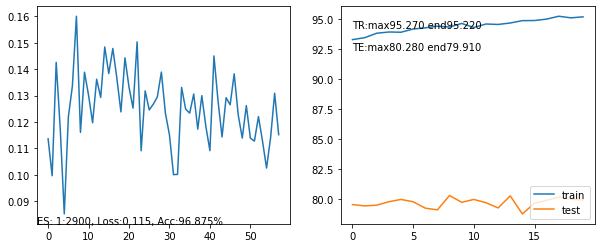

In [33]:
trainer.loop(50)

In [ ]:
dynet.tree.beta_del_neuron

In [34]:
dynet.print_network()

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     272
     ╠════╗
     ║    43
     ╠════╝
    ╔╝
    57
    ╠════╗
    ║    31
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    14
  ╠════╝
 ╔╝
 21
╔╝
│
10


In [ ]:
plt.plot(loss_all)

In [ ]:
plt.plot(accs_all, label="train")
plt.plot(accs_test, label="test")
ymin, ymax = plt.gca().get_ylim()
plt.text(0, 0.8*ymin+0.2*ymax, f"Train-> max:{max(accs_all):.3f} end:{accs_all[-1]:.3f} \nTest-> max:{max(accs_test):.3f} end:{accs_test[-1]:.3f}")
                    
plt.legend()
plt.savefig("files/05_dycnn_cifar10_0.png")

In [ ]:
max(accs_test)

In [ ]:
max(accs_all)

In [ ]:
np.argmax(accs_test)

In [ ]:
len(accs_test)

In [ ]:
dynet.non_linearity.bias